Sanity:
  xp range: 0.4 0.5359181282502993
  xn range: 0.6640818717493665 0.8
  ceL min : 999.637795514978  ceR min: 1000.0


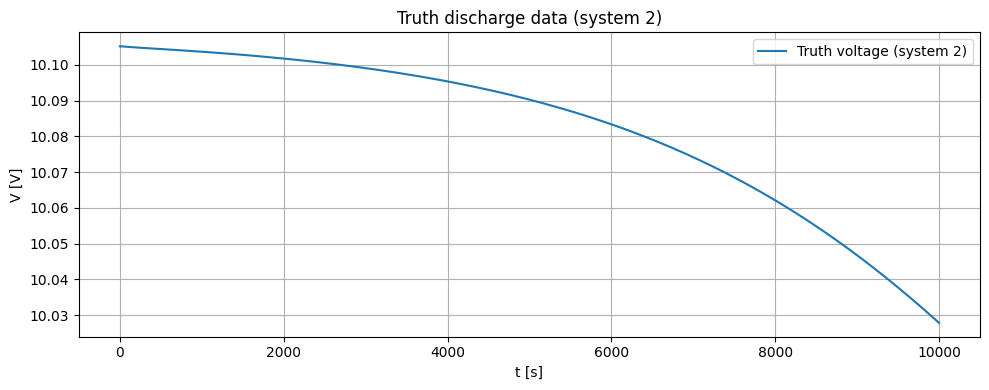

Shapes: t (100001,) U (100001, 1) Y (100001, 1)


In [ ]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import control as ct
from scipy.linalg import block_diag
from IPython.display import display

# =========================================================
# Index map (global)
# =========================================================
# States (SPMe-style reduced MOL):
#   x = [c_n1..c_n4,  c_p1..c_p4,  c_e1..c_e6]
IDX = {
    "cn": slice(0, 4),
    "cp": slice(4, 8),
    "ce": slice(8, 14),

    # "Surface proxy" nodes used in voltage layer
    "cn_surf": 3,    # cn4 -> anode surface
    "cp_surf": 7,    # cp4 -> cathode surface
    "ce_left": 8,    # ce1 (near anode current collector)
    "ce_right": 13,  # ce6 (near cathode current collector)
}

# =========================================================
# Unified parameter block
# =========================================================
@dataclass
class Config:
    # Physical constants
    R: float = 8.314462618
    F: float = 96485.33212
    T: float = 298.15
    T_ref: float = 298.15

    # Geometry
    L1: float = 25e-6
    L2: float = 20e-6
    L3: float = 25e-6
    Rn: float = 5e-6
    Rp: float = 5e-6
    A: float = 1.0

    # Transport
    Dn: float = 1e-14
    Dp: float = 1e-14
    De: float = 7.23e-10
    eps: float = 0.30

    # Effective conductivities for R_el
    kappa_n_eff: float = 1.0
    kappa_s_eff: float = 1.0
    kappa_p_eff: float = 1.0

    # Kinetics / active surface
    a_s_n: float = 1.0e6
    a_s_p: float = 1.0e6
    k_n0: float = 2.0e-11
    k_p0: float = 2.0e-11
    use_arrhenius: bool = False
    Ea_n: float = 0.0
    Ea_p: float = 0.0

    # LAM (optional)
    lam_n: float = 0.0
    lam_p: float = 0.0

    # Capacity-scale (stoichiometries)
    csn_max: float = 3.1e4
    csp_max: float = 3.1e4

    # Electrolyte & electrical
    ce0: float = 1000.0
    t_plus: float = 0.38
    k_f: float = 1.0
    R_ohm: float = 0.0
    use_dynamic_film: bool = False
    Rf: float = 0.0
    L_sei: float = 0.0
    kappa_sei: float = 1.0

    # Flags & conventions
    ce_is_deviation: bool = True
    discharge_positive: bool = True
    ln_orientation: str = "right_over_left"
    eta_mode: str = "diff"

    # Simulation knobs (constant-current embedded)
    I_dyn: float = 2.0
    I_for_voltage: float = 2.0

    # Numerical guards / stability
    theta_guard: float = 1e-3
    I0_floor_p: float = 1e-2
    I0_floor_n: float = 1e-2
    bv_scale: float = 0.7
    N_series: int = 3

# =========================================================
# Simple OCVs
# =========================================================
def ocp_p(xp: np.ndarray) -> np.ndarray:
    x = np.clip(xp, 1e-9, 1 - 1e-9)
    return 4.15 - 0.12 * np.tanh((x - 0.60) / 0.08)

def ocp_n(xn: np.ndarray) -> np.ndarray:
    x = np.clip(xn, 1e-9, 1 - 1e-9)
    return 0.10 + 0.80 * (1.0 / (1.0 + np.exp(-(x - 0.50) / 0.04)))

# =========================================================
# Solid diffusion blocks (4 nodes)
# =========================================================
def build_An(cfg: Config) -> np.ndarray:
    s = cfg.Dn / (cfg.Rn ** 2)
    A = np.zeros((4, 4))
    A[0, 0], A[0, 1] = -24 * s, 24 * s
    A[1, 0], A[1, 1], A[1, 2] = 16 * s, -40 * s, 24 * s
    A[2, 1], A[2, 2], A[2, 3] = 16 * s, -40 * s, 24 * s
    A[3, 2], A[3, 3] = 16 * s, -16 * s
    return A

def build_Bn(cfg: Config) -> np.ndarray:
    sign = -1.0 if cfg.discharge_positive else +1.0
    b = np.zeros((4, 1))
    b[-1, 0] = sign * (6.0 / cfg.Rn) * (1.0 / (cfg.F * cfg.a_s_n * cfg.A * cfg.L1))
    return b

def build_Ap(cfg: Config) -> np.ndarray:
    s = cfg.Dp / (cfg.Rp ** 2)
    A = np.zeros((4, 4))
    A[0, 0], A[0, 1] = -24 * s, 24 * s
    A[1, 0], A[1, 1], A[1, 2] = 16 * s, -40 * s, 24 * s
    A[2, 1], A[2, 2], A[2, 3] = 16 * s, -40 * s, 24 * s
    A[3, 2], A[3, 3] = 16 * s, -16 * s
    return A

def build_Bp(cfg: Config) -> np.ndarray:
    sign = +1.0 if cfg.discharge_positive else -1.0
    b = np.zeros((4, 1))
    b[-1, 0] = sign * (6.0 / cfg.Rp) * (1.0 / (cfg.F * cfg.a_s_p * cfg.A * cfg.L3))
    return b

# =========================================================
# Electrolyte diffusion block (6 nodes)
# =========================================================
def build_Ae(cfg: Config) -> np.ndarray:
    K = cfg.De / cfg.eps
    Ae = np.zeros((6, 6))
    w_in = lambda L: K * 4.0 / (L ** 2)
    w_intf = lambda La, Lb: K * 16.0 / ((La + Lb) ** 2)

    w11 = w_in(cfg.L1)
    w12 = w_intf(cfg.L1, cfg.L2)
    w23 = w_in(cfg.L2)
    w34 = w_intf(cfg.L2, cfg.L3)
    w45 = w_in(cfg.L3)

    Ae[0, 0] = -(w11);                 Ae[0, 1] = +(w11)
    Ae[1, 0] = +(w11); Ae[1, 1] = -(w11 + w12); Ae[1, 2] = +(w12)
    Ae[2, 1] = +(w12); Ae[2, 2] = -(w12 + w23); Ae[2, 3] = +(w23)
    Ae[3, 2] = +(w23); Ae[3, 3] = -(w23 + w34); Ae[3, 4] = +(w34)
    Ae[4, 3] = +(w34); Ae[4, 4] = -(w34 + w45); Ae[4, 5] = +(w45)
    Ae[5, 4] = +(w45); Ae[5, 5] = -(w45)
    return Ae

def build_Be(cfg: Config) -> np.ndarray:
    b = np.zeros((6, 1))
    sign_left = -1.0 if cfg.discharge_positive else +1.0
    sign_right = +1.0 if cfg.discharge_positive else -1.0
    s1 = sign_left * (1.0 - cfg.t_plus) / (cfg.F * cfg.A * cfg.L1 * cfg.eps)
    s3 = sign_right * (1.0 - cfg.t_plus) / (cfg.F * cfg.A * cfg.L3 * cfg.eps)
    b[0, 0] = s1; b[1, 0] = s1
    b[4, 0] = s3; b[5, 0] = s3
    return b

# =========================================================
# Assembly
# =========================================================
def assemble_system(cfg: Config):
    An = build_An(cfg); Ap = build_Ap(cfg); Ae = build_Ae(cfg)
    Bn = build_Bn(cfg); Bp = build_Bp(cfg); Be = build_Be(cfg)

    Aglob = block_diag(An, Ap, Ae)
    Bglob = np.vstack([Bn, Bp, Be])

    state_names = (
        [f"cn{i}" for i in range(1, 5)]
        + [f"cp{i}" for i in range(1, 5)]
        + [f"ce{i}" for i in range(1, 7)]
    )

    S = ct.ss(Aglob, Bglob, np.eye(Aglob.shape[0]), np.zeros((Aglob.shape[0], 1)))
    return S, Aglob, Bglob, (An, Ap, Ae, Bn, Bp, Be), state_names

# =========================================================
# Helpers
# =========================================================
def make_x0(cfg: Config, theta_n0=0.2, theta_p0=0.9, ce0=0.0):
    """
    NOTE: theta_n0/theta_p0 are STOICHIOMETRIES (0..1), not concentrations.
          If cfg.ce_is_deviation=True, ce0 is deviation from cfg.ce0.
    """
    x0 = np.zeros(14)
    x0[IDX["cn"]] = float(theta_n0) * cfg.csn_max
    x0[IDX["cp"]] = float(theta_p0) * cfg.csp_max
    x0[IDX["ce"]] = float(ce0)
    return x0

def plot_states_grouped(t: np.ndarray, X_TN: np.ndarray):
    fig, axs = plt.subplots(3, 1, figsize=(9, 9), sharex=True)
    axs[0].plot(t, X_TN[:, IDX["cn"]]); axs[0].set_title("Negative solid (c_n)")
    axs[1].plot(t, X_TN[:, IDX["cp"]]); axs[1].set_title("Positive solid (c_p)")
    axs[2].plot(t, X_TN[:, IDX["ce"]]); axs[2].set_title("Electrolyte (c_e, deviation)")
    for ax in axs:
        ax.grid(True)
        ax.set_ylabel("State value")
    axs[-1].set_xlabel("Time [s]")
    plt.tight_layout()
    plt.show()

def report_extrema_matrix(X_TN: np.ndarray):
    print("=== State Extrema Summary ===")
    for name in ["cn", "cp", "ce"]:
        arr = X_TN[:, IDX[name]]
        print(f"{name:<8s}: min={arr.min(): .3e}, max={arr.max(): .3e}")

def sanity_checks(cfg: Config, X: np.ndarray):
    """
    X: (N,14) trajectory
    Prints physically-relevant ranges to catch unphysical ICs quickly.
    """
    xp = X[:, IDX["cp_surf"]] / cfg.csp_max
    xn = X[:, IDX["cn_surf"]] / cfg.csn_max

    ceL_raw = X[:, IDX["ce_left"]]
    ceR_raw = X[:, IDX["ce_right"]]
    ceL = (cfg.ce0 + ceL_raw) if cfg.ce_is_deviation else ceL_raw
    ceR = (cfg.ce0 + ceR_raw) if cfg.ce_is_deviation else ceR_raw

    print("Sanity:")
    print("  xp range:", float(np.min(xp)), float(np.max(xp)))
    print("  xn range:", float(np.min(xn)), float(np.max(xn)))
    print("  ceL min :", float(np.min(ceL)), " ceR min:", float(np.min(ceR)))

# =========================================================
# Kinetics & voltage
# =========================================================
def _arrhenius(k0: float, Ea: float, cfg: Config) -> float:
    if (not cfg.use_arrhenius) or (Ea == 0.0):
        return k0
    return k0 * np.exp(-Ea / cfg.R * (1.0 / cfg.T - 1.0 / cfg.T_ref))

def i0_current_scales(xp: float, xn: float, ceL: float, ceR: float, cfg: Config) -> tuple[float, float]:
    """
    Returns total exchange currents (A): (I0p, I0n).
    Includes: theta guards + floors to keep BV stable.
    """
    ce_avg = 0.5 * (ceL + ceR)
    ce_avg = float(np.clip(ce_avg, 1e-12, 10.0 * cfg.ce0))

    xp_eff = float(np.clip(xp, cfg.theta_guard, 1.0 - cfg.theta_guard))
    xn_eff = float(np.clip(xn, cfg.theta_guard, 1.0 - cfg.theta_guard))

    Sp = (1.0 - cfg.lam_p) * cfg.a_s_p * cfg.A * cfg.L3
    Sn = (1.0 - cfg.lam_n) * cfg.a_s_n * cfg.A * cfg.L1

    kp = _arrhenius(cfg.k_p0, cfg.Ea_p, cfg)
    kn = _arrhenius(cfg.k_n0, cfg.Ea_n, cfg)

    i0p = cfg.F * kp * cfg.csp_max * np.sqrt(ce_avg) * np.sqrt(xp_eff * (1.0 - xp_eff))
    i0n = cfg.F * kn * cfg.csn_max * np.sqrt(ce_avg) * np.sqrt(xn_eff * (1.0 - xn_eff))

    I0p = max(float(Sp * i0p), cfg.I0_floor_p)
    I0n = max(float(Sn * i0n), cfg.I0_floor_n)
    return I0p, I0n

def electrolyte_log_term(ceL: float, ceR: float, cfg: Config) -> float:
    ceL = max(ceL, 1e-12)
    ceR = max(ceR, 1e-12)
    ln_arg = (ceR / ceL) if (cfg.ln_orientation == "right_over_left") else (ceL / ceR)
    return (2.0 * cfg.R * cfg.T / cfg.F) * (1.0 - cfg.t_plus) * cfg.k_f * np.log(ln_arg)

def electrolyte_resistance(cfg: Config) -> float:
    return (cfg.L1 / cfg.kappa_n_eff + 2.0 * cfg.L2 / cfg.kappa_s_eff + cfg.L3 / cfg.kappa_p_eff) / (2.0 * cfg.A)

def film_resistance(cfg: Config) -> float:
    if cfg.use_dynamic_film and cfg.L_sei > 0.0:
        return cfg.L_sei / (cfg.kappa_sei * cfg.a_s_n * cfg.A * cfg.L1)
    return cfg.Rf

def terminal_voltage(x: np.ndarray, cfg: Config, I: float | None = None, return_terms: bool = False):
    """
    V_cell = (Up - Un) + bv_scale*(η combo) + Δφ_e - I(R_ohm + R_el + R_film)
    V_pack = N_series * V_cell
    """
    I_use = cfg.I_for_voltage if (I is None) else float(I)

    xp = np.clip(x[IDX["cp_surf"]] / cfg.csp_max, 1e-9, 1 - 1e-9)
    xn = np.clip(x[IDX["cn_surf"]] / cfg.csn_max, 1e-9, 1 - 1e-9)

    Up = float(ocp_p(np.array([xp]))[0])
    Un = float(ocp_n(np.array([xn]))[0])

    ceL_raw = float(x[IDX["ce_left"]])
    ceR_raw = float(x[IDX["ce_right"]])
    ceL = (cfg.ce0 + ceL_raw) if cfg.ce_is_deviation else ceL_raw
    ceR = (cfg.ce0 + ceR_raw) if cfg.ce_is_deviation else ceR_raw

    I0p, I0n = i0_current_scales(xp, xn, ceL, ceR, cfg)
    eta_p = (2.0 * cfg.R * cfg.T / cfg.F) * np.arcsinh(I_use / (2.0 * max(I0p, 1e-20)))
    eta_n = (2.0 * cfg.R * cfg.T / cfg.F) * np.arcsinh(I_use / (2.0 * max(I0n, 1e-20)))

    eta_p *= cfg.bv_scale
    eta_n *= cfg.bv_scale

    eta_combo = (eta_p - eta_n) if (cfg.eta_mode == "diff") else (eta_p + eta_n)
    dphi_e = electrolyte_log_term(ceL, ceR, cfg)
    ohmic = -I_use * (cfg.R_ohm + electrolyte_resistance(cfg) + film_resistance(cfg))

    V_cell = (Up - Un) + eta_combo + dphi_e + ohmic
    V_pack = cfg.N_series * V_cell

    if not return_terms:
        return float(V_pack)

    return float(V_pack), {
        "Up": Up, "Un": Un, "Udiff": Up - Un,
        "eta_p": float(eta_p), "eta_n": float(eta_n), "eta_combo": float(eta_combo),
        "dphi_e": float(dphi_e), "ohmic": float(ohmic), "I_use": float(I_use),
        "xp": float(xp), "xn": float(xn), "ceL": float(ceL), "ceR": float(ceR),
        "I0p": float(I0p), "I0n": float(I0n),
        "R_el": electrolyte_resistance(cfg), "R_film": film_resistance(cfg),
    }

# =========================================================
# Nonlinear IOSystem (A,B driven by I_dyn; output uses same I)
# =========================================================
def battery_update(t, x, u, params):
    A = params["A"]; B = params["B"]; cfg = params["cfg"]
    return (A @ x + B[:, 0] * cfg.I_dyn)

def battery_output(t, x, u, params):
    cfg = params["cfg"]
    V = terminal_voltage(x, cfg, I=cfg.I_dyn, return_terms=False)
    return np.hstack([x, V])

# =========================================================
# Data generator for sys-id (truth data)
# =========================================================
def generate_discharge_data(
    cfg: Config,
    I_const: float = 2.0,
    sim_t_end: float = 100.0,
    sim_dt: float = 0.1,
    theta_n0: float = 0.8,
    theta_p0: float = 0.4,
    ce0: float = 0.0,
):
    T = np.arange(0.0, sim_t_end + sim_dt, sim_dt)

    cfg.I_dyn = float(I_const)
    cfg.I_for_voltage = float(I_const)

    _, A, B, _, state_names = assemble_system(cfg)
    nl_params = dict(A=A, B=B, cfg=cfg)

    battery_nl = ct.nlsys(
        battery_update,
        battery_output,
        name="battery_unified_cfg",
        params=nl_params,
        states=state_names,
        outputs=state_names + ["V_pack_constI"],
        inputs=0,
    )

    x0 = make_x0(cfg, theta_n0=theta_n0, theta_p0=theta_p0, ce0=ce0)
    resp = ct.input_output_response(battery_nl, T, 0, X0=x0)

    X = resp.states.T
    Y_full = resp.outputs.T
    V = Y_full[:, -1:]

    U = np.full((len(T), 1), float(I_const))
    return T, U, X, V, Y_full

# =========================================================
# --- Stage 1: Generate truth data (SYSTEM 2) ---
# =========================================================
CFG = Config()
t, U, X, Y, Y_full = generate_discharge_data(
    CFG,
    I_const=2.0,
    # sim_t_end=10_000.0,
    sim_t_end=100.0,
    sim_dt=0.1,
    theta_n0=0.8,   # MUST be 0..1 (stoich)
    theta_p0=0.4,   # MUST be 0..1 (stoich)
    ce0=0.0         # deviation about ce0 when ce_is_deviation=True
)

sanity_checks(CFG, X)

plt.figure(figsize=(10, 4))
plt.plot(t, Y, label="Truth voltage (system 2)")
plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title("Truth discharge data (system 2)")
plt.ticklabel_format(axis="y", style="plain", useOffset=False)  # <-- key
plt.legend(); plt.tight_layout(); plt.show()

print("Shapes:", "t", t.shape, "U", U.shape, "Y", Y.shape)



R_fixed (cell): 4.5e-05
Init Gamma_p0,Gamma_n0: 1.49552264786 1.49552264786
Init Ke_phys: 0.03185879811065222
Init extra R0: 9.999999999999982e-09
Pre-fit max abs(Y0-Y): 6.543996278196573e-08


  0%|                        |

Solving NLP with Adam (18 optimization variables) ...


100%|████████████████████████|
    f =   0.000003, f* =  0.000003, |grad f| =  0.000000, iter = 500


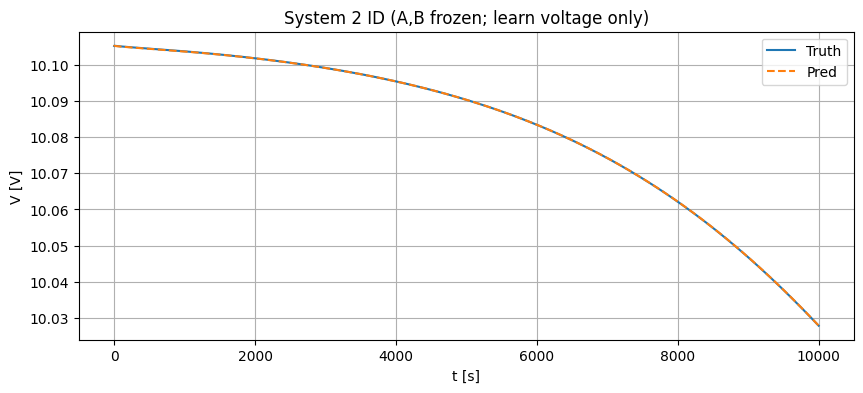

Learned:
  Gamma_p : 1.33839
  Gamma_n : 1.34626
  K_e     : 0.0487909
  R0      : 1.62283e-08
Post-fit max abs(Yhat-Y): 8.539363084025808e-05
Post-fit mean(Yhat-Y): 6.441929158786943e-07


In [2]:
# =========================================================
# --- Stage 2: JAX-SysID model (robust, copy-paste) ---
# =========================================================
import jax
import jax.numpy as jnp
import diffrax
import numpy as np
import matplotlib.pyplot as plt
from jax_sysid.models import CTModel

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)
DTYPE = jnp.float64

FREEZE_AB = True

# Fixed cell-level ohmic term from truth model
R_fixed = float(CFG.R_ohm + electrolyte_resistance(CFG) + film_resistance(CFG))
print("R_fixed (cell):", R_fixed)

# Truth A,B
_, A_true_np, B_true_np, _, _ = assemble_system(CFG)
A_true = jnp.array(A_true_np, dtype=DTYPE)
B_true = jnp.array(B_true_np, dtype=DTYPE)

@jax.jit
def ocp_p_jax(xp):
    xp = jnp.clip(xp, 1e-9, 1 - 1e-9)
    return 4.15 - 0.12 * jnp.tanh((xp - 0.60) / 0.08)

@jax.jit
def ocp_n_jax(xn):
    xn = jnp.clip(xn, 1e-9, 1 - 1e-9)
    return 0.10 + 0.80 * (1.0 / (1.0 + jnp.exp(-(xn - 0.50) / 0.04)))

def theta_map(raw_theta: jnp.ndarray) -> dict:
    """
    Learn ONLY: Gamma_p, Gamma_n, K_e, R0_extra
    Keep csn_max/csp_max fixed to CFG to avoid ill-conditioning.
    """
    Gamma_p = jnp.exp(raw_theta[0])
    Gamma_n = jnp.exp(raw_theta[1])
    K_e     = jnp.exp(raw_theta[2])
    R0      = jnp.exp(raw_theta[3])  # extra >= 0
    return dict(
        csn_max=DTYPE(CFG.csn_max),
        csp_max=DTYPE(CFG.csp_max),
        Gamma_p=Gamma_p,
        Gamma_n=Gamma_n,
        K_e=K_e,
        R0=R0,
    )

def voltage_from_params(x, I, p: dict):
    xp = jnp.clip(x[7] / p["csp_max"], 1e-9, 1 - 1e-9)
    xn = jnp.clip(x[3] / p["csn_max"], 1e-9, 1 - 1e-9)

    Up = ocp_p_jax(xp)
    Un = ocp_n_jax(xn)

    ceL_raw = x[8]
    ceR_raw = x[13]
    ceL = (DTYPE(CFG.ce0) + ceL_raw) if CFG.ce_is_deviation else ceL_raw
    ceR = (DTYPE(CFG.ce0) + ceR_raw) if CFG.ce_is_deviation else ceR_raw
    ceL = jnp.maximum(ceL, 1e-12)
    ceR = jnp.maximum(ceR, 1e-12)
    ce_avg = jnp.clip(0.5 * (ceL + ceR), 1e-12, 1e12)

    xp_eff = jnp.clip(xp, CFG.theta_guard, 1.0 - CFG.theta_guard)
    xn_eff = jnp.clip(xn, CFG.theta_guard, 1.0 - CFG.theta_guard)

    denom_p = p["Gamma_p"] * jnp.sqrt(ce_avg) * jnp.sqrt(xp_eff * (1-xp_eff)) + 1e-18
    denom_n = p["Gamma_n"] * jnp.sqrt(ce_avg) * jnp.sqrt(xn_eff * (1-xn_eff)) + 1e-18

    kappa = (2.0 * DTYPE(CFG.R) * DTYPE(CFG.T) / DTYPE(CFG.F))
    eta_p = DTYPE(CFG.bv_scale) * kappa * jnp.arcsinh(I / (2.0 * denom_p))
    eta_n = DTYPE(CFG.bv_scale) * kappa * jnp.arcsinh(I / (2.0 * denom_n))
    eta_combo = (eta_p - eta_n) if (CFG.eta_mode == "diff") else (eta_p + eta_n)

    ln_arg = (ceR / ceL) if (CFG.ln_orientation == "right_over_left") else (ceL / ceR)
    dphi_e = p["K_e"] * jnp.log(jnp.maximum(ln_arg, 1e-12))

    # MATCH truth: fixed physics + extra learnable lump
    ohmic = -I * (DTYPE(R_fixed) + p["R0"])

    V_cell = (Up - Un) + eta_combo + dphi_e + ohmic
    return DTYPE(CFG.N_series) * V_cell

@jax.jit
def state_fcn(x, u, t, params):
    (raw_theta,) = params
    I = u[0]
    return A_true @ x + (B_true[:, 0] * I)

@jax.jit
def output_fcn(x, u, t, params):
    (raw_theta,) = params
    p = theta_map(raw_theta)
    I = u[0]
    V = voltage_from_params(x, I, p)
    return jnp.array([V], dtype=DTYPE)

# Data
t_np = np.asarray(t, dtype=np.float64).reshape(-1)
U_np = np.asarray(U, dtype=np.float64).reshape(-1, 1)
Y_np = np.asarray(Y, dtype=np.float64).reshape(-1, 1)

nx, ny, nu = 14, 1, 1
model = CTModel(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)

# ---- init theta (4 params now) ----
def implied_gamma_from_truth(x, cfg):
    xp = np.clip(x[IDX["cp_surf"]] / cfg.csp_max, 1e-9, 1-1e-9)
    xn = np.clip(x[IDX["cn_surf"]] / cfg.csn_max, 1e-9, 1-1e-9)

    ceL_raw = float(x[IDX["ce_left"]])
    ceR_raw = float(x[IDX["ce_right"]])
    ceL = (cfg.ce0 + ceL_raw) if cfg.ce_is_deviation else ceL_raw
    ceR = (cfg.ce0 + ceR_raw) if cfg.ce_is_deviation else ceR_raw
    ce_avg = float(np.clip(0.5 * (ceL + ceR), 1e-12, 1e12))

    xp_eff = float(np.clip(xp, cfg.theta_guard, 1.0-cfg.theta_guard))
    xn_eff = float(np.clip(xn, cfg.theta_guard, 1.0-cfg.theta_guard))
    s_p = np.sqrt(ce_avg) * np.sqrt(xp_eff*(1-xp_eff))
    s_n = np.sqrt(ce_avg) * np.sqrt(xn_eff*(1-xn_eff))

    I0p, I0n = i0_current_scales(xp, xn, ceL, ceR, cfg)
    Gamma_p = float(I0p / max(s_p, 1e-18))
    Gamma_n = float(I0n / max(s_n, 1e-18))
    return Gamma_p, Gamma_n

Gs = np.array([implied_gamma_from_truth(X[k, :], CFG) for k in range(X.shape[0])])
Gamma_p0 = np.median(Gs[:, 0])
Gamma_n0 = np.median(Gs[:, 1])
Ke_phys = (2.0 * CFG.R * CFG.T / CFG.F) * (1.0 - CFG.t_plus) * CFG.k_f

theta0_raw = np.array([
    np.log(Gamma_p0),
    np.log(Gamma_n0),
    np.log(Ke_phys),
    np.log(1e-8),         # extra R0 starts tiny
], dtype=np.float64)

print("Init Gamma_p0,Gamma_n0:", Gamma_p0, Gamma_n0)
print("Init Ke_phys:", Ke_phys)
print("Init extra R0:", np.exp(theta0_raw[3]))

model.init(params=[theta0_raw], x0=np.array(X[0], dtype=np.float64))

# ---- IMPORTANT: avoid saturation + freeze x0 strongly ----
# If CTModel.loss supports xsat, pass it. Otherwise just crank rho_x0.
try:
    model.loss(rho_x0=0.0, rho_th=1e-8, xsat=1e9)
except TypeError:
    model.loss(rho_x0=0.0, rho_th=1e-8)

model.optimization(adam_epochs=500, lbfgs_epochs=0, adam_eta=1e-3)

model.integration_options(
    ode_solver=diffrax.Tsit5(),                 # explicit is fine here (linear ODE)
    dt0=float(t_np[1] - t_np[0]) / 50.0,
    max_steps=5_000_000,
    stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-9),
)

# ---- pre-fit check: should already be ~0 ----
Y0, X0 = model.predict(model.x0, U_np, t_np)
print("Pre-fit max abs(Y0-Y):", float(np.max(np.abs(np.asarray(Y0) - Y_np))))

# Fit + plot
model.fit(Y_np, U_np, t_np)
Yhat, _ = model.predict(model.x0, U_np, t_np)

plt.figure(figsize=(10,4))
plt.plot(t_np, Y_np[:,0], label="Truth")
plt.plot(t_np, Yhat[:,0], "--", label="Pred")
plt.grid(True); plt.legend(); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.ticklabel_format(axis="y", style="plain", useOffset=False)
plt.title("System 2 ID (A,B frozen; learn voltage only)")
plt.show()

p_final = theta_map(jnp.array(model.params[0]))
print("Learned:")
for k,v in p_final.items():
    if k in ("csn_max","csp_max"): 
        continue
    print(f"  {k:8s}: {float(v):.6g}")
    
    
post_err = float(np.max(np.abs(np.asarray(Yhat) - Y_np)))
print("Post-fit max abs(Yhat-Y):", post_err)
print("Post-fit mean(Yhat-Y):", float(np.mean(np.asarray(Yhat) - Y_np)))



R_fixed (cell): 4.5e-05
Init Gamma_p0,Gamma_n0: 1.49552264786 1.49552264786
Init Ke_phys: 0.03185879811065222
Init extra R0: 9.999999999999982e-09
Pre-fit max abs(Y0-Y): 6.541720942720985e-08


  0%|                        |

Solving NLP with Adam (18 optimization variables) ...


100%|████████████████████████|
    f =   0.000003, f* =  0.000003, |grad f| =  0.000000, iter = 500


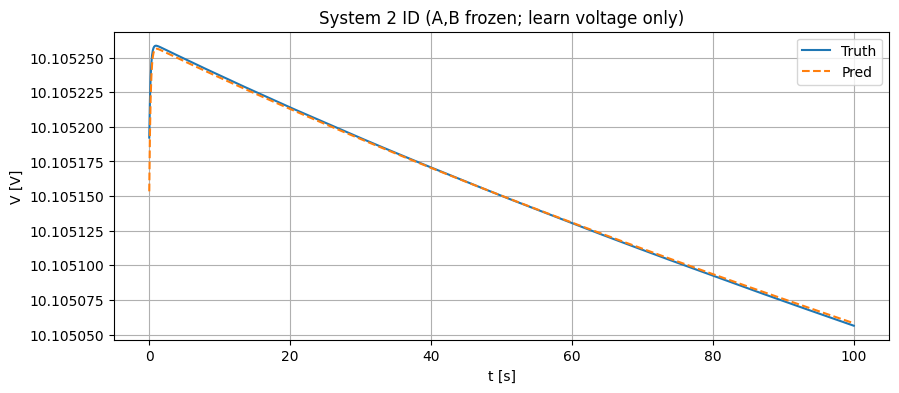

Learned:
  Gamma_p : 1.23005
  Gamma_n : 1.26406
  K_e     : 0.0487992
  R0      : 1.62283e-08
Post-fit max abs(Yhat-Y): 3.880237208520043e-05
Post-fit mean(Yhat-Y): -7.362505877777609e-08


In [5]:
# =========================================================
# --- Stage 2: JAX-SysID model (robust, copy-paste) ---
# =========================================================
import jax
import jax.numpy as jnp
import diffrax
import numpy as np
import matplotlib.pyplot as plt
from jax_sysid.models import CTModel

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)
DTYPE = jnp.float64

FREEZE_AB = True

# Fixed cell-level ohmic term from truth model
R_fixed = float(CFG.R_ohm + electrolyte_resistance(CFG) + film_resistance(CFG))
print("R_fixed (cell):", R_fixed)

# Truth A,B
_, A_true_np, B_true_np, _, _ = assemble_system(CFG)
A_true = jnp.array(A_true_np, dtype=DTYPE)
B_true = jnp.array(B_true_np, dtype=DTYPE)

@jax.jit
def ocp_p_jax(xp):
    xp = jnp.clip(xp, 1e-9, 1 - 1e-9)
    return 4.15 - 0.12 * jnp.tanh((xp - 0.60) / 0.08)

@jax.jit
def ocp_n_jax(xn):
    xn = jnp.clip(xn, 1e-9, 1 - 1e-9)
    return 0.10 + 0.80 * (1.0 / (1.0 + jnp.exp(-(xn - 0.50) / 0.04)))

def theta_map(raw_theta: jnp.ndarray) -> dict:
    """
    Learn ONLY: Gamma_p, Gamma_n, K_e, R0_extra
    Keep csn_max/csp_max fixed to CFG to avoid ill-conditioning.
    """
    Gamma_p = jnp.exp(raw_theta[0])
    Gamma_n = jnp.exp(raw_theta[1])
    K_e     = jnp.exp(raw_theta[2])
    R0      = jnp.exp(raw_theta[3])  # extra >= 0
    return dict(
        csn_max=DTYPE(CFG.csn_max),
        csp_max=DTYPE(CFG.csp_max),
        Gamma_p=Gamma_p,
        Gamma_n=Gamma_n,
        K_e=K_e,
        R0=R0,
    )

def voltage_from_params(x, I, p: dict):
    xp = jnp.clip(x[7] / p["csp_max"], 1e-9, 1 - 1e-9)
    xn = jnp.clip(x[3] / p["csn_max"], 1e-9, 1 - 1e-9)

    Up = ocp_p_jax(xp)
    Un = ocp_n_jax(xn)

    ceL_raw = x[8]
    ceR_raw = x[13]
    ceL = (DTYPE(CFG.ce0) + ceL_raw) if CFG.ce_is_deviation else ceL_raw
    ceR = (DTYPE(CFG.ce0) + ceR_raw) if CFG.ce_is_deviation else ceR_raw
    ceL = jnp.maximum(ceL, 1e-12)
    ceR = jnp.maximum(ceR, 1e-12)
    ce_avg = jnp.clip(0.5 * (ceL + ceR), 1e-12, 1e12)

    xp_eff = jnp.clip(xp, CFG.theta_guard, 1.0 - CFG.theta_guard)
    xn_eff = jnp.clip(xn, CFG.theta_guard, 1.0 - CFG.theta_guard)

    denom_p = p["Gamma_p"] * jnp.sqrt(ce_avg) * jnp.sqrt(xp_eff * (1-xp_eff)) + 1e-18
    denom_n = p["Gamma_n"] * jnp.sqrt(ce_avg) * jnp.sqrt(xn_eff * (1-xn_eff)) + 1e-18

    kappa = (2.0 * DTYPE(CFG.R) * DTYPE(CFG.T) / DTYPE(CFG.F))
    eta_p = DTYPE(CFG.bv_scale) * kappa * jnp.arcsinh(I / (2.0 * denom_p))
    eta_n = DTYPE(CFG.bv_scale) * kappa * jnp.arcsinh(I / (2.0 * denom_n))
    eta_combo = (eta_p - eta_n) if (CFG.eta_mode == "diff") else (eta_p + eta_n)

    ln_arg = (ceR / ceL) if (CFG.ln_orientation == "right_over_left") else (ceL / ceR)
    dphi_e = p["K_e"] * jnp.log(jnp.maximum(ln_arg, 1e-12))

    # MATCH truth: fixed physics + extra learnable lump
    ohmic = -I * (DTYPE(R_fixed) + p["R0"])

    V_cell = (Up - Un) + eta_combo + dphi_e + ohmic
    return DTYPE(CFG.N_series) * V_cell

@jax.jit
def state_fcn(x, u, t, params):
    (raw_theta,) = params
    I = u[0]
    return A_true @ x + (B_true[:, 0] * I)

@jax.jit
def output_fcn(x, u, t, params):
    (raw_theta,) = params
    p = theta_map(raw_theta)
    I = u[0]
    V = voltage_from_params(x, I, p)
    return jnp.array([V], dtype=DTYPE)

# Data
t_np = np.asarray(t, dtype=np.float64).reshape(-1)
U_np = np.asarray(U, dtype=np.float64).reshape(-1, 1)
Y_np = np.asarray(Y, dtype=np.float64).reshape(-1, 1)

nx, ny, nu = 14, 1, 1
model = CTModel(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)

# ---- init theta (4 params now) ----
def implied_gamma_from_truth(x, cfg):
    xp = np.clip(x[IDX["cp_surf"]] / cfg.csp_max, 1e-9, 1-1e-9)
    xn = np.clip(x[IDX["cn_surf"]] / cfg.csn_max, 1e-9, 1-1e-9)

    ceL_raw = float(x[IDX["ce_left"]])
    ceR_raw = float(x[IDX["ce_right"]])
    ceL = (cfg.ce0 + ceL_raw) if cfg.ce_is_deviation else ceL_raw
    ceR = (cfg.ce0 + ceR_raw) if cfg.ce_is_deviation else ceR_raw
    ce_avg = float(np.clip(0.5 * (ceL + ceR), 1e-12, 1e12))

    xp_eff = float(np.clip(xp, cfg.theta_guard, 1.0-cfg.theta_guard))
    xn_eff = float(np.clip(xn, cfg.theta_guard, 1.0-cfg.theta_guard))
    s_p = np.sqrt(ce_avg) * np.sqrt(xp_eff*(1-xp_eff))
    s_n = np.sqrt(ce_avg) * np.sqrt(xn_eff*(1-xn_eff))

    I0p, I0n = i0_current_scales(xp, xn, ceL, ceR, cfg)
    Gamma_p = float(I0p / max(s_p, 1e-18))
    Gamma_n = float(I0n / max(s_n, 1e-18))
    return Gamma_p, Gamma_n

Gs = np.array([implied_gamma_from_truth(X[k, :], CFG) for k in range(X.shape[0])])
Gamma_p0 = np.median(Gs[:, 0])
Gamma_n0 = np.median(Gs[:, 1])
Ke_phys = (2.0 * CFG.R * CFG.T / CFG.F) * (1.0 - CFG.t_plus) * CFG.k_f

theta0_raw = np.array([
    np.log(Gamma_p0),
    np.log(Gamma_n0),
    np.log(Ke_phys),
    np.log(1e-8),         # extra R0 starts tiny
], dtype=np.float64)

print("Init Gamma_p0,Gamma_n0:", Gamma_p0, Gamma_n0)
print("Init Ke_phys:", Ke_phys)
print("Init extra R0:", np.exp(theta0_raw[3]))

model.init(params=[theta0_raw], x0=np.array(X[0], dtype=np.float64))

# ---- IMPORTANT: avoid saturation + freeze x0 strongly ----
# If CTModel.loss supports xsat, pass it. Otherwise just crank rho_x0.
try:
    model.loss(rho_x0=0.0, rho_th=1e-8, xsat=1e9)
except TypeError:
    model.loss(rho_x0=0.0, rho_th=1e-8)

model.optimization(adam_epochs=500, lbfgs_epochs=0, adam_eta=1e-3)

model.integration_options(
    ode_solver=diffrax.Tsit5(),                 # explicit is fine here (linear ODE)
    dt0=float(t_np[1] - t_np[0]) / 50.0,
    max_steps=5_000_000,
    stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-9),
)

# ---- pre-fit check: should already be ~0 ----
Y0, X0 = model.predict(model.x0, U_np, t_np)
print("Pre-fit max abs(Y0-Y):", float(np.max(np.abs(np.asarray(Y0) - Y_np))))

# Fit + plot
model.fit(Y_np, U_np, t_np)
Yhat, _ = model.predict(model.x0, U_np, t_np)

plt.figure(figsize=(10,4))
plt.plot(t_np, Y_np[:,0], label="Truth")
plt.plot(t_np, Yhat[:,0], "--", label="Pred")
plt.grid(True); plt.legend(); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.ticklabel_format(axis="y", style="plain", useOffset=False)
plt.title("System 2 ID (A,B frozen; learn voltage only)")
plt.show()

p_final = theta_map(jnp.array(model.params[0]))
print("Learned:")
for k,v in p_final.items():
    if k in ("csn_max","csp_max"): 
        continue
    print(f"  {k:8s}: {float(v):.6g}")
    
    
post_err = float(np.max(np.abs(np.asarray(Yhat) - Y_np)))
print("Post-fit max abs(Yhat-Y):", post_err)
print("Post-fit mean(Yhat-Y):", float(np.mean(np.asarray(Yhat) - Y_np)))



In [43]:
# # OR show the droop clearly:
# plt.figure(figsize=(10, 4))
# plt.plot(t, (Y - Y[0]), label="ΔV (system 2)")
# plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("ΔV [V]")
# plt.title("System 2 voltage change relative to t=0")
# plt.legend(); plt.tight_layout(); plt.show()


In [44]:
# CFG = Config()

# t1, U1, X1, Y1, _ = generate_discharge_data(CFG, I_const=2.0, sim_t_end=100.0,   sim_dt=0.1,
#                                             theta_n0=0.8, theta_p0=0.4, ce0=0.0)

# t2, U2, X2, Y2, _ = generate_discharge_data(CFG, I_const=2.0, sim_t_end=10_000.0, sim_dt=0.1,
#                                             theta_n0=0.8, theta_p0=0.4, ce0=0.0)

# # Compare first 100 s of the long run
# mask = t2 <= 100.0
# Y2_100 = Y2[mask]

# print("Max abs diff (first 100s):", np.max(np.abs(Y1[:,0] - Y2_100[:,0])))

# plt.figure(figsize=(10,4))
# plt.plot(t1, Y1[:,0], label="sim_t_end=100")
# plt.plot(t2[mask], Y2_100[:,0], "--", label="first 100s of sim_t_end=10k")
# plt.grid(True); plt.legend(); plt.xlabel("t [s]"); plt.ylabel("V [V]")
# plt.tight_layout(); plt.show()


In [45]:
# CFG = Config()

# tL, UL, XL, YL, _ = generate_discharge_data(CFG, I_const=2.0, sim_t_end=10_000.0, sim_dt=0.1,
#                                             theta_n0=0.8, theta_p0=0.4, ce0=0.0)

# tS, US, XS, YS, _ = generate_discharge_data(CFG, I_const=2.0, sim_t_end=100.0, sim_dt=0.1,
#                                             theta_n0=0.8, theta_p0=0.4, ce0=0.0)

# # Compare first 100 s of the long run with the short run
# mask = tL <= 100.0

# plt.figure(figsize=(10,4))
# plt.plot(tS, YS[:,0], label="Short run (0–100s)")
# plt.plot(tL[mask], YL[mask,0], "--", label="Long run sliced (0–100s)")
# plt.grid(True); plt.legend(); plt.xlabel("t [s]"); plt.ylabel("V [V]")
# plt.title("Consistency check: first 100s must match")
# plt.show()

# print("max |ΔV| over first 100s =", np.max(np.abs(YS[:,0] - YL[mask,0])))


R_fixed (cell): 4.5e-05
Median implied Gamma_p, Gamma_n: 1.49552264786 1.49552264786
Init extra R0: 9.999999999999982e-09
Max |X0 - X| : 0.0019275647646281868
pred finite? True
state finite? True
Max abs diff pred vs truth: 6.732236812467818e-08
Max abs diff (JAX voltage on truth X vs Y): 6.000000318806542e-08
Mean diff (JAX - Truth): -5.999999956081929e-08


  0%|                        |

Solving NLP with Adam (20 optimization variables) ...


100%|████████████████████████|
    f =  307505.150547, f* =  307505.150547, |grad f| =  11.090666, iter = 500


You may have to increase the values of 'xsat' or 'rho_x0'


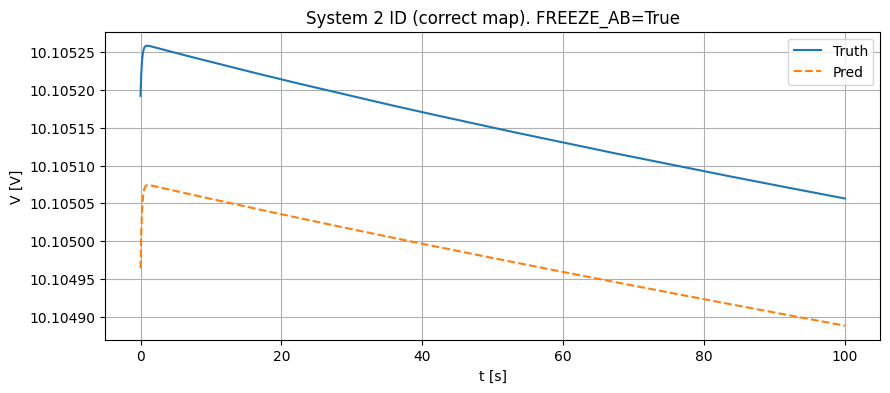

Learned:
  csn_max : 26116.2
  csp_max : 30558.7
  Gamma_p : 0.920849
  Gamma_n : 2.29922
  K_e     : 0.0519713
  R0      : 1.64421e-08


In [46]:
# =========================================================
# --- Stage 2: JAX-SysID model (corrected) ---
# =========================================================
import jax
import jax.numpy as jnp
import diffrax
import numpy as np
import matplotlib.pyplot as plt
from jax_sysid.models import CTModel

# --- IMPORTANT: match Bemporad example (x64) ---
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

DTYPE = jnp.float64

FREEZE_AB = True   # start True, only turn False after voltage layer fits

# Fixed physics-based resistance term from your truth model (cell-level)
R_fixed = float(CFG.R_ohm + electrolyte_resistance(CFG) + film_resistance(CFG))
print("R_fixed (cell):", R_fixed)

# Precompute truth A,B (continuous-time)
_, A_true_np, B_true_np, _, _ = assemble_system(CFG)
A_true = jnp.array(A_true_np, dtype=DTYPE)
B_true = jnp.array(B_true_np, dtype=DTYPE)

@jax.jit
def ocp_p_jax(xp):
    xp = jnp.clip(xp, 1e-9, 1 - 1e-9)
    return 4.15 - 0.12 * jnp.tanh((xp - 0.60) / 0.08)

@jax.jit
def ocp_n_jax(xn):
    xn = jnp.clip(xn, 1e-9, 1 - 1e-9)
    return 0.10 + 0.80 * (1.0 / (1.0 + jnp.exp(-(xn - 0.50) / 0.04)))

def theta_map(raw_theta: jnp.ndarray) -> dict:
    """
    Map raw optimizer variables -> physical params (positive via exp).
    Here R0 is ONLY the *extra* lumped resistance beyond R_fixed.
    """
    csn_max = jnp.exp(raw_theta[0])
    csp_max = jnp.exp(raw_theta[1])
    Gamma_p = jnp.exp(raw_theta[2])
    Gamma_n = jnp.exp(raw_theta[3])
    K_e     = jnp.exp(raw_theta[4])
    R0      = jnp.exp(raw_theta[5])   # extra ohmic >= 0

    out = dict(csn_max=csn_max, csp_max=csp_max,
               Gamma_p=Gamma_p, Gamma_n=Gamma_n,
               K_e=K_e, R0=R0)

    if not FREEZE_AB:
        thA = jnp.exp(raw_theta[6:13])
        thB = jnp.exp(raw_theta[13:17])

        sign_n     = -1.0 if CFG.discharge_positive else +1.0
        sign_p     = +1.0 if CFG.discharge_positive else -1.0
        sign_left  = -1.0 if CFG.discharge_positive else +1.0
        sign_right = +1.0 if CFG.discharge_positive else -1.0

        out.update(dict(
            thA=thA,
            th8  = sign_n     * thB[0],
            th9  = sign_p     * thB[1],
            th10 = sign_left  * thB[2],
            th11 = sign_right * thB[3],
        ))
    return out

def build_A_B_from_theta_dict(p: dict):
    th1, th2, th3, th4, th5, th6, th7 = p["thA"]

    A = jnp.zeros((14,14), dtype=DTYPE)

    base4 = jnp.array([
        [-24., 24.,  0.,  0.],
        [ 16.,-40., 24.,  0.],
        [  0., 16.,-40., 24.],
        [  0.,  0., 16.,-16.],
    ], dtype=DTYPE)

    A = A.at[0:4, 0:4].set(th1 * base4)
    A = A.at[4:8, 4:8].set(th2 * base4)

    Ae = jnp.array([
        [-4*th3,  4*th3,      0.,       0.,       0.,      0.],
        [ 4*th3, -(4*th3 + 16*th4), 16*th4, 0.,    0.,      0.],
        [ 0.,     16*th4, -(16*th4 + 4*th5), 4*th5, 0.,     0.],
        [ 0.,      0.,     4*th5, -(4*th5 + 16*th6), 16*th6, 0.],
        [ 0.,      0.,      0.,     16*th6, -(16*th6 + 4*th7), 4*th7],
        [ 0.,      0.,      0.,      0.,     4*th7,   -4*th7],
    ], dtype=DTYPE)

    A = A.at[8:14, 8:14].set(Ae)

    B = jnp.zeros((14,1), dtype=DTYPE)
    B = B.at[3,0].set(6.0 * p["th8"])
    B = B.at[7,0].set(6.0 * p["th9"])
    B = B.at[8,0].set(p["th10"])
    B = B.at[9,0].set(p["th10"])
    B = B.at[12,0].set(p["th11"])
    B = B.at[13,0].set(p["th11"])
    return A, B

def voltage_from_params(x, I, p: dict):
    xp = jnp.clip(x[7] / p["csp_max"], 1e-9, 1 - 1e-9)
    xn = jnp.clip(x[3] / p["csn_max"], 1e-9, 1 - 1e-9)

    Up = ocp_p_jax(xp)
    Un = ocp_n_jax(xn)

    ceL_raw = x[8]
    ceR_raw = x[13]
    ceL = (CFG.ce0 + ceL_raw) if CFG.ce_is_deviation else ceL_raw
    ceR = (CFG.ce0 + ceR_raw) if CFG.ce_is_deviation else ceR_raw
    ceL = jnp.maximum(ceL, 1e-12)
    ceR = jnp.maximum(ceR, 1e-12)
    ce_avg = jnp.clip(0.5 * (ceL + ceR), 1e-12, 1e12)

    xp_eff = jnp.clip(xp, CFG.theta_guard, 1.0 - CFG.theta_guard)
    xn_eff = jnp.clip(xn, CFG.theta_guard, 1.0 - CFG.theta_guard)

    denom_p = p["Gamma_p"] * jnp.sqrt(ce_avg) * jnp.sqrt(xp_eff * (1-xp_eff)) + 1e-18
    denom_n = p["Gamma_n"] * jnp.sqrt(ce_avg) * jnp.sqrt(xn_eff * (1-xn_eff)) + 1e-18

    kappa = (2.0 * CFG.R * CFG.T / CFG.F)
    eta_p = CFG.bv_scale * kappa * jnp.arcsinh(I / (2.0 * denom_p))
    eta_n = CFG.bv_scale * kappa * jnp.arcsinh(I / (2.0 * denom_n))
    eta_combo = (eta_p - eta_n) if (CFG.eta_mode == "diff") else (eta_p + eta_n)

    ln_arg = (ceR / ceL) if (CFG.ln_orientation == "right_over_left") else (ceL / ceR)
    dphi_e = p["K_e"] * jnp.log(jnp.maximum(ln_arg, 1e-12))

    # Ohmic: truth physics + learnable extra lump
    ohmic = -I * (DTYPE(R_fixed) + p["R0"])

    V_cell = (Up - Un) + eta_combo + dphi_e + ohmic
    return CFG.N_series * V_cell

@jax.jit
def state_fcn(x, u, t, params):
    (raw_theta,) = params
    p = theta_map(raw_theta)
    I = u[0]
    if FREEZE_AB:
        A, B = A_true, B_true
    else:
        A, B = build_A_B_from_theta_dict(p)
    return A @ x + (B[:,0] * I)

@jax.jit
def output_fcn(x, u, t, params):
    (raw_theta,) = params
    p = theta_map(raw_theta)
    I = u[0]
    V = voltage_from_params(x, I, p)
    return jnp.array([V], dtype=DTYPE)

# -------------------------
# Data (NO scaling for now)
# -------------------------
t_np = np.asarray(t, dtype=np.float64).reshape(-1)
U_np = np.asarray(U, dtype=np.float64).reshape(-1,1)
Y_np = np.asarray(Y, dtype=np.float64).reshape(-1,1)

nx, ny, nu = 14, 1, 1
model = CTModel(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)

# params (freeze A,B -> only 6 parameters)
nparams = 6 if FREEZE_AB else (6 + 11)

theta0_raw = np.zeros(nparams, dtype=np.float64)
theta0_raw[0] = np.log(CFG.csn_max)
theta0_raw[1] = np.log(CFG.csp_max)

# --- Gamma init from truth (your helper) ---
def implied_gamma_from_truth(x, cfg):
    xp = np.clip(x[IDX["cp_surf"]] / cfg.csp_max, 1e-9, 1-1e-9)
    xn = np.clip(x[IDX["cn_surf"]] / cfg.csn_max, 1e-9, 1-1e-9)

    ceL_raw = float(x[IDX["ce_left"]])
    ceR_raw = float(x[IDX["ce_right"]])
    ceL = (cfg.ce0 + ceL_raw) if cfg.ce_is_deviation else ceL_raw
    ceR = (cfg.ce0 + ceR_raw) if cfg.ce_is_deviation else ceR_raw
    ce_avg = 0.5 * (ceL + ceR)
    ce_avg = float(np.clip(ce_avg, 1e-12, 1e12))

    xp_eff = float(np.clip(xp, cfg.theta_guard, 1.0-cfg.theta_guard))
    xn_eff = float(np.clip(xn, cfg.theta_guard, 1.0-cfg.theta_guard))
    s_p = np.sqrt(ce_avg) * np.sqrt(xp_eff*(1-xp_eff))
    s_n = np.sqrt(ce_avg) * np.sqrt(xn_eff*(1-xn_eff))

    I0p, I0n = i0_current_scales(xp, xn, ceL, ceR, cfg)
    Gamma_p = float(I0p / max(s_p, 1e-18))
    Gamma_n = float(I0n / max(s_n, 1e-18))
    return Gamma_p, Gamma_n

Gs = np.array([implied_gamma_from_truth(X[k,:], CFG) for k in range(X.shape[0])])
Gamma_p0 = np.median(Gs[:,0])
Gamma_n0 = np.median(Gs[:,1])
print("Median implied Gamma_p, Gamma_n:", Gamma_p0, Gamma_n0)

theta0_raw[2] = np.log(Gamma_p0)
theta0_raw[3] = np.log(Gamma_n0)

Ke_phys = (2.0 * CFG.R * CFG.T / CFG.F) * (1.0 - CFG.t_plus) * CFG.k_f
theta0_raw[4] = np.log(Ke_phys)

# IMPORTANT: R0 is EXTRA (since R_fixed already included)
theta0_raw[5] = np.log(1e-8)
print("Init extra R0:", np.exp(theta0_raw[5]))

model.init(params=[theta0_raw], x0=np.array(X[0], dtype=np.float64))

model.loss(rho_x0=1e-4, rho_th=1e-6)
model.optimization(adam_epochs=500, lbfgs_epochs=0, adam_eta=1e-3)

model.integration_options(
    ode_solver=diffrax.Kvaerno5(),
    dt0=float(t_np[1] - t_np[0]) / 50.0,
    max_steps=5_000_000,
    stepsize_controller=diffrax.PIDController(rtol=1e-4, atol=1e-7),
)

# -------------------------
# Pre-fit checks
# -------------------------
Y0, X0 = model.predict(model.x0, U_np, t_np)

X0_np = np.asarray(X0)
print("Max |X0 - X| :", float(np.max(np.abs(X0_np - X))))
print("pred finite?", np.isfinite(np.asarray(Y0)).all())
print("state finite?", np.isfinite(np.asarray(X0)).all())
print("Max abs diff pred vs truth:", float(np.max(np.abs(np.asarray(Y0) - Y_np))))

# Voltage-on-truth-states check (should now be ~0)
p0 = theta_map(jnp.array(theta0_raw))
X_j = jnp.array(X, dtype=DTYPE)
I_j = jnp.array(U_np[:,0], dtype=DTYPE)
V_jax_on_truth = jax.vmap(lambda x, I: voltage_from_params(x, I, p0))(X_j, I_j)
V_jax_on_truth = np.asarray(V_jax_on_truth).reshape(-1,1)

print("Max abs diff (JAX voltage on truth X vs Y):", float(np.max(np.abs(V_jax_on_truth - Y_np))))
print("Mean diff (JAX - Truth):", float(np.mean(V_jax_on_truth - Y_np)))

# If the above is near zero, then enable fitting:
# model.fit(Y_np, U_np, t_np)
# Fit
model.fit(Y_np, U_np, t_np)

# Predict
Yhat, _ = model.predict(model.x0, U_np, t_np)

plt.figure(figsize=(10,4))
plt.plot(t_np, Y_np[:,0], label="Truth")
plt.plot(t_np, Yhat[:,0], "--", label="Pred")
plt.grid(True); plt.legend(); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.ticklabel_format(axis="y", style="plain", useOffset=False)
plt.title(f"System 2 ID (correct map). FREEZE_AB={FREEZE_AB}")
plt.show()

p_final = theta_map(jnp.array(model.params[0]))
print("Learned:")
for k,v in p_final.items():
    print(f"  {k:8s}: {float(v):.6g}")



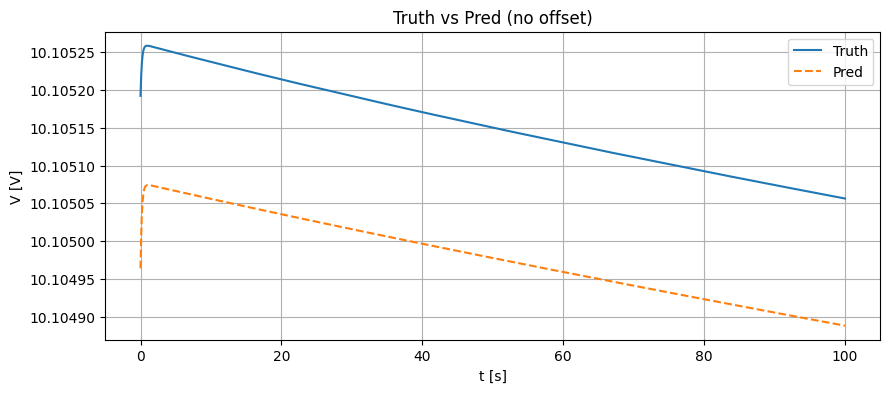

In [47]:
plt.figure(figsize=(10,4))
plt.plot(t_np, Y_np[:,0], label="Truth")
plt.plot(t_np, Yhat[:,0], "--", label="Pred")
plt.grid(True); plt.legend(); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.ticklabel_format(axis="y", style="plain", useOffset=False)
plt.title("Truth vs Pred (no offset)")
plt.show()


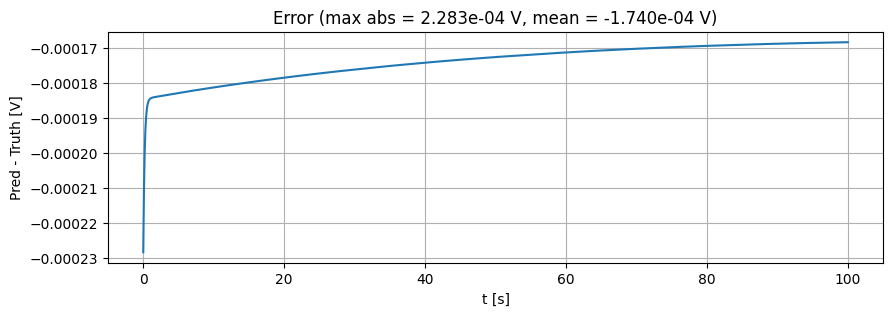

In [48]:
err = (Yhat[:,0] - Y_np[:,0])
plt.figure(figsize=(10,3))
plt.plot(t_np, err)
plt.grid(True)
plt.xlabel("t [s]"); plt.ylabel("Pred - Truth [V]")
plt.ticklabel_format(axis="y", style="plain", useOffset=False)
plt.title(f"Error (max abs = {np.max(np.abs(err)):.3e} V, mean = {np.mean(err):.3e} V)")
plt.show()


Median implied Gamma_p, Gamma_n: 1.49552264786 1.49552264786
Max |X0 - X| : 0.0019275647646281868
Max |X0[0]-X[0]| : 0.0
pred finite? True
state finite? True
Y0 range: 10.105050366431936 10.105252635428002
X0 max abs: 24800.0
Truth Y range: 10.105056366876445 10.105258636046916
Recomputed truth-from-states range: 10.105056366876445 10.105258636046916
Max abs diff (Y vs truth-from-states): 0.0
Max abs diff pred vs truth: 6.007322367551637e-06
Max abs diff (JAX voltage on truth X vs Y): 6.000000002615025e-06
Mean diff (JAX - Truth): -5.999999999401256e-06
Python V0: 10.105192261997058
{'Up': 4.268393715778172, 'Un': 0.8995577770904611, 'Udiff': 3.3688359386877114, 'eta_p': 0.0015520380700406683, 'eta_n': 0.0019005560920656059, 'eta_combo': -0.00034851802202493756, 'dphi_e': 0.0, 'ohmic': -9e-05, 'I_use': 2.0, 'xp': 0.4, 'xn': 0.8, 'ceL': 1000.0, 'ceR': 1000.0, 'I0p': 23.168537236151195, 'I0n': 18.91703143841416, 'R_el': 4.5e-05, 'R_film': 0.0}
JAX V0: 10.105456261997059
Up-Un: 3.36883593

  0%|                        |

Solving NLP with Adam (20 optimization variables) ...


  0%|                        |

100%|████████████████████████|
    f =  307505.150403, f* =  307505.150403, |grad f| =  11.090657, iter = 500


You may have to increase the values of 'xsat' or 'rho_x0'


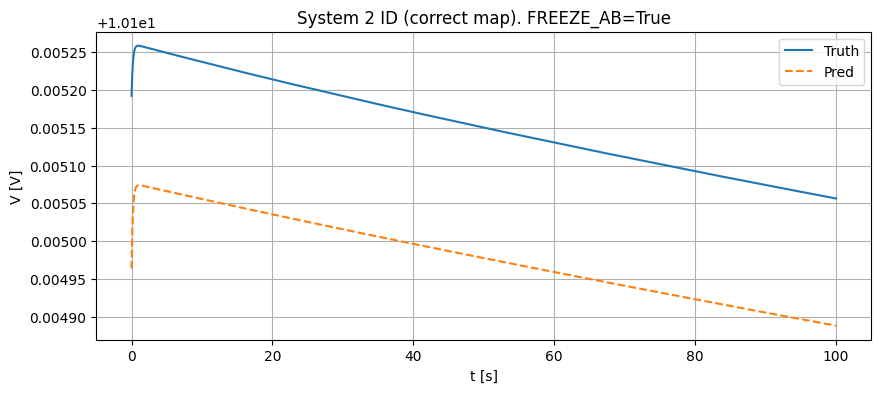

Learned:
  csn_max : 26116.8
  csp_max : 30561.4
  Gamma_p : 0.920788
  Gamma_n : 2.30006
  K_e     : 0.0519713
  R0      : 1.64324e-06


In [32]:
# =========================================================
# --- Stage 2: JAX-SysID model (corrected) ---
# =========================================================
import jax
import jax.numpy as jnp
import diffrax
import numpy as np
import matplotlib.pyplot as plt
from jax_sysid.models import CTModel

# --- IMPORTANT: match Bemporad example (x64) ---
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

R_fixed = CFG.R_ohm + electrolyte_resistance(CFG) + film_resistance(CFG)
R_fixed = float(R_fixed)


DTYPE = jnp.float64

FREEZE_AB = True   # start True, only turn False after voltage layer fits

# Precompute truth A,B
_, A_true_np, B_true_np, _, _ = assemble_system(CFG)
A_true = jnp.array(A_true_np, dtype=DTYPE)
B_true = jnp.array(B_true_np, dtype=DTYPE)

@jax.jit
def ocp_p_jax(xp):
    xp = jnp.clip(xp, 1e-9, 1 - 1e-9)
    return 4.15 - 0.12 * jnp.tanh((xp - 0.60) / 0.08)

@jax.jit
def ocp_n_jax(xn):
    xn = jnp.clip(xn, 1e-9, 1 - 1e-9)
    return 0.10 + 0.80 * (1.0 / (1.0 + jnp.exp(-(xn - 0.50) / 0.04)))

def theta_map(raw_theta: jnp.ndarray) -> dict:
    """
    Correct map:
      - use exp for big positive parameters (csmax, Gamma, Ke, R0)
    """
    csn_max = jnp.exp(raw_theta[0])          # ~3e4
    csp_max = jnp.exp(raw_theta[1])
    Gamma_p = jnp.exp(raw_theta[2])          # O(1..1e3) depending on your definition
    Gamma_n = jnp.exp(raw_theta[3])
    K_e     = jnp.exp(raw_theta[4])          # log-term prefactor
    R0      = jnp.exp(raw_theta[5])          # ohmic >= 0

    out = dict(csn_max=csn_max, csp_max=csp_max,
               Gamma_p=Gamma_p, Gamma_n=Gamma_n,
               K_e=K_e, R0=R0)

    if not FREEZE_AB:
        thA = jnp.exp(raw_theta[6:13])       # theta1..theta7
        thB = jnp.exp(raw_theta[13:17])      # magnitudes for theta8..theta11

        sign_n     = -1.0 if CFG.discharge_positive else +1.0
        sign_p     = +1.0 if CFG.discharge_positive else -1.0
        sign_left  = -1.0 if CFG.discharge_positive else +1.0
        sign_right = +1.0 if CFG.discharge_positive else -1.0

        out.update(dict(
            thA=thA,
            th8 = sign_n     * thB[0],
            th9 = sign_p     * thB[1],
            th10= sign_left  * thB[2],
            th11= sign_right * thB[3],
        ))
    return out

def build_A_B_from_theta_dict(p: dict):
    th1, th2, th3, th4, th5, th6, th7 = p["thA"]

    A = jnp.zeros((14,14), dtype=DTYPE)

    base4 = jnp.array([
        [-24., 24.,  0.,  0.],
        [ 16.,-40., 24.,  0.],
        [  0., 16.,-40., 24.],
        [  0.,  0., 16.,-16.],
    ], dtype=DTYPE)

    A = A.at[0:4, 0:4].set(th1 * base4)
    A = A.at[4:8, 4:8].set(th2 * base4)

    Ae = jnp.array([
        [-4*th3,  4*th3,      0.,       0.,       0.,      0.],
        [ 4*th3, -(4*th3 + 16*th4), 16*th4, 0.,    0.,      0.],
        [ 0.,     16*th4, -(16*th4 + 4*th5), 4*th5, 0.,     0.],
        [ 0.,      0.,     4*th5, -(4*th5 + 16*th6), 16*th6, 0.],
        [ 0.,      0.,      0.,     16*th6, -(16*th6 + 4*th7), 4*th7],
        [ 0.,      0.,      0.,      0.,     4*th7,   -4*th7],
    ], dtype=DTYPE)

    A = A.at[8:14, 8:14].set(Ae)

    B = jnp.zeros((14,1), dtype=DTYPE)
    B = B.at[3,0].set(6.0 * p["th8"])
    B = B.at[7,0].set(6.0 * p["th9"])
    B = B.at[8,0].set(p["th10"])
    B = B.at[9,0].set(p["th10"])
    B = B.at[12,0].set(p["th11"])
    B = B.at[13,0].set(p["th11"])
    return A, B

def voltage_from_params(x, I, p: dict):
    xp = jnp.clip(x[7] / p["csp_max"], 1e-9, 1 - 1e-9)
    xn = jnp.clip(x[3] / p["csn_max"], 1e-9, 1 - 1e-9)

    Up = ocp_p_jax(xp)
    Un = ocp_n_jax(xn)

    ceL_raw = x[8]
    ceR_raw = x[13]
    ceL = (CFG.ce0 + ceL_raw) if CFG.ce_is_deviation else ceL_raw
    ceR = (CFG.ce0 + ceR_raw) if CFG.ce_is_deviation else ceR_raw
    ceL = jnp.maximum(ceL, 1e-12)
    ceR = jnp.maximum(ceR, 1e-12)
    ce_avg = jnp.clip(0.5 * (ceL + ceR), 1e-12, 1e12)

    # BV
    xp_eff = jnp.clip(xp, CFG.theta_guard, 1.0 - CFG.theta_guard)
    xn_eff = jnp.clip(xn, CFG.theta_guard, 1.0 - CFG.theta_guard)

    denom_p = p["Gamma_p"] * jnp.sqrt(ce_avg) * jnp.sqrt(xp_eff * (1-xp_eff)) + 1e-18
    denom_n = p["Gamma_n"] * jnp.sqrt(ce_avg) * jnp.sqrt(xn_eff * (1-xn_eff)) + 1e-18

    kappa = (2.0 * CFG.R * CFG.T / CFG.F)
    eta_p = CFG.bv_scale * kappa * jnp.arcsinh(I / (2.0 * denom_p))
    eta_n = CFG.bv_scale * kappa * jnp.arcsinh(I / (2.0 * denom_n))
    eta_combo = (eta_p - eta_n) if (CFG.eta_mode == "diff") else (eta_p + eta_n)

    # Electrolyte log
    ln_arg = (ceR / ceL) if (CFG.ln_orientation == "right_over_left") else (ceL / ceR)
    dphi_e = p["K_e"] * jnp.log(jnp.maximum(ln_arg, 1e-12))

    # Ohmic: match truth structure
    ohmic = -I * (DTYPE(R_fixed) + p["R0"])


    V_cell = (Up - Un) + eta_combo + dphi_e + ohmic
    return CFG.N_series * V_cell

@jax.jit
def state_fcn(x, u, t, params):
    (raw_theta,) = params
    p = theta_map(raw_theta)
    I = u[0]
    if FREEZE_AB:
        A, B = A_true, B_true
    else:
        A, B = build_A_B_from_theta_dict(p)
    return A @ x + (B[:,0] * I)

@jax.jit
def output_fcn(x, u, t, params):
    (raw_theta,) = params
    p = theta_map(raw_theta)
    I = u[0]
    V = voltage_from_params(x, I, p)
    return jnp.array([V], dtype=DTYPE)

# -------------------------
# Data (NO scaling for now)
# -------------------------
t_np = np.asarray(t, dtype=np.float64).reshape(-1)
U_np = np.asarray(U, dtype=np.float64).reshape(-1,1)
Y_np = np.asarray(Y, dtype=np.float64).reshape(-1,1)

nx, ny, nu = 14, 1, 1
model = CTModel(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)

# params
nparams = 6 if FREEZE_AB else (6 + 11)

theta0_raw = np.zeros(nparams, dtype=np.float64)
theta0_raw[0] = np.log(CFG.csn_max)
theta0_raw[1] = np.log(CFG.csp_max)
theta0_raw[2] = np.log(1.0)              # Gamma_p init
theta0_raw[3] = np.log(1.0)              # Gamma_n init

def implied_gamma_from_truth(x, cfg):
    # compute I0p, I0n from your truth function
    xp = np.clip(x[IDX["cp_surf"]] / cfg.csp_max, 1e-9, 1-1e-9)
    xn = np.clip(x[IDX["cn_surf"]] / cfg.csn_max, 1e-9, 1-1e-9)

    ceL_raw = float(x[IDX["ce_left"]])
    ceR_raw = float(x[IDX["ce_right"]])
    ceL = (cfg.ce0 + ceL_raw) if cfg.ce_is_deviation else ceL_raw
    ceR = (cfg.ce0 + ceR_raw) if cfg.ce_is_deviation else ceR_raw
    ce_avg = 0.5 * (ceL + ceR)
    ce_avg = float(np.clip(ce_avg, 1e-12, 1e12))

    xp_eff = float(np.clip(xp, cfg.theta_guard, 1.0-cfg.theta_guard))
    xn_eff = float(np.clip(xn, cfg.theta_guard, 1.0-cfg.theta_guard))
    s_p = np.sqrt(ce_avg) * np.sqrt(xp_eff*(1-xp_eff))
    s_n = np.sqrt(ce_avg) * np.sqrt(xn_eff*(1-xn_eff))

    I0p, I0n = i0_current_scales(xp, xn, ceL, ceR, cfg)

    # your JAX denom is: Gamma * s
    # truth uses denom = I0 (because arcsinh(I/(2*I0)))
    # so Gamma should be ~ I0 / s
    Gamma_p = float(I0p / max(s_p, 1e-18))
    Gamma_n = float(I0n / max(s_n, 1e-18))
    return Gamma_p, Gamma_n


Gs = np.array([implied_gamma_from_truth(X[k,:], CFG) for k in range(X.shape[0])])
Gamma_p0 = np.median(Gs[:,0])
Gamma_n0 = np.median(Gs[:,1])
print("Median implied Gamma_p, Gamma_n:", Gamma_p0, Gamma_n0)

theta0_raw[2] = np.log(Gamma_p0)
theta0_raw[3] = np.log(Gamma_n0)

# Physics-based initial Ke (good starting point)
Ke_phys = (2.0 * CFG.R * CFG.T / CFG.F) * (1.0 - CFG.t_plus) * CFG.k_f
theta0_raw[4] = np.log(Ke_phys)

# Initial R0 (small but nonzero)
# R0_phys = CFG.R_ohm + electrolyte_resistance(CFG) + film_resistance(CFG)
# theta0_raw[5] = np.log(R0_phys + 1e-12)   # small guard for log
# print("Init R0_phys:", R0_phys)
theta0_raw[5] = np.log(1e-6)


if not FREEZE_AB:
    theta0_raw[6:13]  = np.log(1e-3)     # A lumps
    theta0_raw[13:17] = np.log(1e-7)     # B magnitudes

model.init(params=[theta0_raw], x0=np.array(X[0], dtype=np.float64))

model.loss(rho_x0=1e-4, rho_th=1e-6)      # much lighter regularization initially
model.optimization(adam_epochs=500, lbfgs_epochs=0, adam_eta=1e-3)

# Start with Bemporad-style simple integrator (debug), then move to Tsit5
# model.integration_options(
#     ode_solver=diffrax.Heun(),
#     dt0=float(t_np[1] - t_np[0]),
#     max_steps=200_000,
# )

model.integration_options(
    ode_solver=diffrax.Kvaerno5(),
    dt0=float(t_np[1] - t_np[0]) / 50.0,
    max_steps=5_000_000,
    stepsize_controller=diffrax.PIDController(rtol=1e-4, atol=1e-7),
)


# model.integration_options(
#     ode_solver=diffrax.Tsit5(),
#     dt0=float(t_np[1] - t_np[0]) / 200.0,  # 0.0005 if Ts=0.1
#     max_steps=5_000_000,
#     stepsize_controller=diffrax.PIDController(rtol=1e-4, atol=1e-7),
# )

# # model.integration_options(
# #     ode_solver=diffrax.Heun(),
# #     dt0=float(t[1] - t[0]),     # try dt = sample time first
# #     max_steps=200_000,
# # )

# model.integration_options(
#     ode_solver=diffrax.Kvaerno5(),  # implicit, good for stiff-ish
#     dt0=float(t[1] - t[0]) / 50.0,  
#     max_steps=5_000_000,
#     stepsize_controller=diffrax.PIDController(rtol=1e-4, atol=1e-7),
# )

Y0, X0 = model.predict(model.x0, U_np, t_np)

X0_np = np.asarray(X0)
print("Max |X0 - X| :", float(np.max(np.abs(X0_np - X))))
print("Max |X0[0]-X[0]| :", float(np.max(np.abs(X0_np[0] - X[0]))))



print("pred finite?", np.isfinite(np.asarray(Y0)).all())
print("state finite?", np.isfinite(np.asarray(X0)).all())
print("Y0 range:", float(np.min(Y0)), float(np.max(Y0)))
print("X0 max abs:", float(np.max(np.abs(X0))))

V_truth_from_X = np.array([terminal_voltage(X[k, :], CFG, I=CFG.I_dyn) for k in range(X.shape[0])])
V_truth_from_X = V_truth_from_X.reshape(-1, 1)

print("Truth Y range:", Y_np.min(), Y_np.max())
print("Recomputed truth-from-states range:", V_truth_from_X.min(), V_truth_from_X.max())
print("Max abs diff (Y vs truth-from-states):", np.max(np.abs(Y_np - V_truth_from_X)))





print("Max abs diff pred vs truth:", float(np.max(np.abs(np.asarray(Y0) - Y_np))))

# build params dict p0 from your initial theta0_raw
p0 = theta_map(jnp.array(theta0_raw))

X_j = jnp.array(X, dtype=DTYPE)
I_j = jnp.array(U_np[:,0], dtype=DTYPE)   # I(t) = 2 everywhere here

V_jax_on_truth = jax.vmap(lambda x, I: voltage_from_params(x, I, p0))(X_j, I_j)
V_jax_on_truth = np.asarray(V_jax_on_truth).reshape(-1,1)

print("Max abs diff (JAX voltage on truth X vs Y):", float(np.max(np.abs(V_jax_on_truth - Y_np))))
print("Mean diff (JAX - Truth):", float(np.mean(V_jax_on_truth - Y_np)))

V_py0, terms = terminal_voltage(X[0], CFG, I=CFG.I_dyn, return_terms=True)
print("Python V0:", V_py0)
print(terms)

x0j = jnp.array(X[0], dtype=DTYPE)
p0 = theta_map(jnp.array(theta0_raw))
I0 = DTYPE(2.0)

# replicate pieces
xp = jnp.clip(x0j[7] / p0["csp_max"], 1e-9, 1-1e-9)
xn = jnp.clip(x0j[3] / p0["csn_max"], 1e-9, 1-1e-9)
Up = ocp_p_jax(xp); Un = ocp_n_jax(xn)

ceL_raw = x0j[8]; ceR_raw = x0j[13]
ceL = (CFG.ce0 + ceL_raw) if CFG.ce_is_deviation else ceL_raw
ceR = (CFG.ce0 + ceR_raw) if CFG.ce_is_deviation else ceR_raw
ceL = jnp.maximum(ceL, 1e-12); ceR = jnp.maximum(ceR, 1e-12)
ce_avg = jnp.clip(0.5*(ceL+ceR), 1e-12, 1e12)

xp_eff = jnp.clip(xp, CFG.theta_guard, 1-CFG.theta_guard)
xn_eff = jnp.clip(xn, CFG.theta_guard, 1-CFG.theta_guard)
den_p = p0["Gamma_p"]*jnp.sqrt(ce_avg)*jnp.sqrt(xp_eff*(1-xp_eff)) + 1e-18
den_n = p0["Gamma_n"]*jnp.sqrt(ce_avg)*jnp.sqrt(xn_eff*(1-xn_eff)) + 1e-18

kappa = (2.0 * CFG.R * CFG.T / CFG.F)
eta_p = CFG.bv_scale*kappa*jnp.arcsinh(I0/(2*den_p))
eta_n = CFG.bv_scale*kappa*jnp.arcsinh(I0/(2*den_n))
eta_combo = eta_p - eta_n

ln_arg = ceR/ceL
dphi_e = p0["K_e"] * jnp.log(jnp.maximum(ln_arg, 1e-12))
ohmic = -I0 * p0["R0"]

V0_j = CFG.N_series*((Up-Un) + eta_combo + dphi_e + ohmic)

print("JAX V0:", float(V0_j))
print("Up-Un:", float(Up-Un), "eta_combo:", float(eta_combo), "dphi_e:", float(dphi_e), "ohmic:", float(ohmic))



# Fit
model.fit(Y_np, U_np, t_np)

# Predict
Yhat, _ = model.predict(model.x0, U_np, t_np)

plt.figure(figsize=(10,4))
plt.plot(t_np, Y_np[:,0], label="Truth")
plt.plot(t_np, Yhat[:,0], "--", label="Pred")
plt.grid(True); plt.legend(); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title(f"System 2 ID (correct map). FREEZE_AB={FREEZE_AB}")
plt.show()

p_final = theta_map(jnp.array(model.params[0]))
print("Learned:")
for k,v in p_final.items():
    print(f"  {k:8s}: {float(v):.6g}")


In [ ]:
# =========================================================
# --- Stage 2: JAX-SysID model (System 2 ID-friendly) ---
#   - FIX OCV initially
#   - Learn: cmax_n, cmax_p, Gamma_p, Gamma_n, K_e, R0
#   - Optionally freeze A,B from config to debug
# =========================================================
import jax
import jax.numpy as jnp
import diffrax
import numpy as np
import matplotlib.pyplot as plt
from jax_sysid.models import CTModel
from jax_sysid.utils import standard_scale, unscale

# -------------------------
# Utilities
# -------------------------
def ensure_N1(a, name, N):
    a = np.asarray(a)
    if a.ndim == 1:
        a = a.reshape(-1, 1)
    if a.shape[0] != N and a.shape[1] == N:
        a = a.T
    assert a.shape[0] == N, f"{name}.shape {a.shape} must have first dim = {N}"
    return a

def softplus(x):
    return jnp.log1p(jnp.exp(-jnp.abs(x))) + jnp.maximum(x, 0)

# -------------------------
# Debug knobs (IMPORTANT)
# -------------------------
FREEZE_AB = True      # <-- set True to debug voltage layer first
LEARN_Ke  = True      # log-term prefactor K_e
LEARN_R0  = True      # constant ohmic R0

# -------------------------
# Precompute "truth" A,B from your System 2 builder (debug only)
# -------------------------
# You already have assemble_system(cfg) from Stage 1
_, A_true_np, B_true_np, _, _ = assemble_system(CFG)
A_true = jnp.array(A_true_np, dtype=jnp.float32)
B_true = jnp.array(B_true_np, dtype=jnp.float32)

# -------------------------
# Fixed OCV (same as System 2 truth)
# -------------------------
@jax.jit
def ocp_p_jax(xp):
    xp = jnp.clip(xp, 1e-9, 1 - 1e-9)
    return 4.15 - 0.12 * jnp.tanh((xp - 0.60) / 0.08)

@jax.jit
def ocp_n_jax(xn):
    xn = jnp.clip(xn, 1e-9, 1 - 1e-9)
    return 0.10 + 0.80 * (1.0 / (1.0 + jnp.exp(-(xn - 0.50) / 0.04)))

# =========================================================
# Parameter vector design (RAW)
# =========================================================
# raw_theta length = 6 (core voltage params) + optionally AB params (11)
#
# Voltage params (always present):
#   0: log(csn_max) or raw -> positive
#   1: log(csp_max)
#   2: log(Gamma_p)
#   3: log(Gamma_n)
#   4: log(K_e)   (if LEARN_Ke else fixed)
#   5: log(R0)    (if LEARN_R0 else fixed)
#
# If FREEZE_AB=False, append 11 raw values for theta1..theta11 (A,B)
#   6..12: A diffusion lumps theta1..theta7 (positive)
#   13..16: B lumps theta8..theta11 (can be +/-; but we keep sign convention fixed and learn magnitudes)
#
# Note: If you want to allow signs for B, you can keep them unconstrained.
#       For stability, we learn magnitudes with exp/softplus and apply known signs.

def theta_map(raw_theta: jnp.ndarray) -> dict:
    """
    Returns a dict of physical params.
    Uses softplus to enforce positivity where needed.
    """
    # ----- voltage layer -----
    csn_max = softplus(raw_theta[0]) + 1e-6
    csp_max = softplus(raw_theta[1]) + 1e-6
    Gamma_p = softplus(raw_theta[2]) + 1e-8
    Gamma_n = softplus(raw_theta[3]) + 1e-8

    if LEARN_Ke:
        K_e = softplus(raw_theta[4]) + 1e-8
    else:
        # fixed physics prefactor:
        K_e = (2.0 * CFG.R * CFG.T / CFG.F) * (1.0 - CFG.t_plus) * CFG.k_f

    if LEARN_R0:
        R0 = softplus(raw_theta[5])  # allow 0+
    else:
        # fixed from config (R_ohm + R_el + film). You can compute exactly if desired.
        R0 = 0.0

    out = dict(
        csn_max=csn_max, csp_max=csp_max,
        Gamma_p=Gamma_p, Gamma_n=Gamma_n,
        K_e=K_e, R0=R0
    )

    # ----- A,B optional -----
    if not FREEZE_AB:
        # raw_theta[6:13] -> theta1..theta7 positive
        thA = jnp.exp(raw_theta[6:13])
        # raw_theta[13:17] -> magnitudes for theta8..theta11
        thBmag = jnp.exp(raw_theta[13:17])

        # Apply known signs for discharge_positive convention
        # In your System 2 truth:
        #   Bn has sign_left = -1 (discharge_positive True)
        #   Bp has sign_right = +1
        #   Be: left negative, right positive (already inside theta10/theta11 sign usage if you build that way)
        #
        # Here, we keep the same sign conventions as your original theta8..theta11 definitions:
        #   theta8 = sign_n * 1/(Rn F a_s_n A L1)    -> negative when discharge_positive True
        #   theta9 = sign_p * 1/(Rp F a_s_p A L3)    -> positive when discharge_positive True
        #   theta10 = sign_left*(1-t+)/(...L1 eps)   -> negative when discharge_positive True
        #   theta11 = sign_right*(1-t+)/(...L3 eps)  -> positive when discharge_positive True
        sign_n = -1.0 if CFG.discharge_positive else +1.0
        sign_p = +1.0 if CFG.discharge_positive else -1.0
        sign_left  = -1.0 if CFG.discharge_positive else +1.0
        sign_right = +1.0 if CFG.discharge_positive else -1.0

        th8  = sign_n    * thBmag[0]
        th9  = sign_p    * thBmag[1]
        th10 = sign_left * thBmag[2]
        th11 = sign_right* thBmag[3]

        out.update(dict(thA=thA, th8=th8, th9=th9, th10=th10, th11=th11))

    return out

# -------------------------
# A,B builder (if not frozen)
# -------------------------
def build_A_B_from_theta_dict(p: dict):
    thA = p["thA"]  # 7 entries
    th1, th2, th3, th4, th5, th6, th7 = thA

    A = jnp.zeros((14, 14), dtype=jnp.float32)

    An = th1 * jnp.array([
        [-24., 24., 0., 0.],
        [16., -40., 24., 0.],
        [0., 16., -40., 24.],
        [0., 0., 16., -16.],
    ], dtype=jnp.float32)
    A = A.at[0:4, 0:4].set(An)

    Ap = th2 * jnp.array([
        [-24., 24., 0., 0.],
        [16., -40., 24., 0.],
        [0., 16., -40., 24.],
        [0., 0., 16., -16.],
    ], dtype=jnp.float32)
    A = A.at[4:8, 4:8].set(Ap)

    Ae = jnp.array([
        [-4*th3,  4*th3,      0.,       0.,       0.,      0.],
        [ 4*th3, -(4*th3 + 16*th4), 16*th4, 0.,    0.,      0.],
        [ 0.,     16*th4, -(16*th4 + 4*th5), 4*th5, 0.,     0.],
        [ 0.,      0.,     4*th5, -(4*th5 + 16*th6), 16*th6, 0.],
        [ 0.,      0.,      0.,     16*th6, -(16*th6 + 4*th7), 4*th7],
        [ 0.,      0.,      0.,      0.,     4*th7,   -4*th7],
    ], dtype=jnp.float32)
    A = A.at[8:14, 8:14].set(Ae)

    B = jnp.zeros((14, 1), dtype=jnp.float32)
    B = B.at[3, 0].set(6.0 * p["th8"])
    B = B.at[7, 0].set(6.0 * p["th9"])
    B = B.at[8, 0].set(p["th10"])
    B = B.at[9, 0].set(p["th10"])
    B = B.at[12, 0].set(p["th11"])
    B = B.at[13, 0].set(p["th11"])

    return A, B

# -------------------------
# Voltage layer (fixed OCV + learnable cmax/Gamma/K_e/R0)
# -------------------------
def voltage_from_params(x, I, p: dict):
    # surface stoichiometries with learnable cmax
    xp = jnp.clip(x[7] / p["csp_max"], 1e-6, 1.0 - 1e-6)
    xn = jnp.clip(x[3] / p["csn_max"], 1e-6, 1.0 - 1e-6)

    # electrolyte
    ceL_raw = x[8]
    ceR_raw = x[13]
    ceL = (CFG.ce0 + ceL_raw) if CFG.ce_is_deviation else ceL_raw
    ceR = (CFG.ce0 + ceR_raw) if CFG.ce_is_deviation else ceR_raw
    ceL = jnp.maximum(ceL, 1e-6)
    ceR = jnp.maximum(ceR, 1e-6)
    ce_avg = jnp.clip(0.5 * (ceL + ceR), 1e-6, 1e9)

    # OCV fixed
    Up = ocp_p_jax(xp)
    Un = ocp_n_jax(xn)

    # BV (System 2 style): asinh(I/(2*I0)), with damping bv_scale
    theta_guard = CFG.theta_guard
    xp_eff = jnp.clip(xp, theta_guard, 1.0 - theta_guard)
    xn_eff = jnp.clip(xn, theta_guard, 1.0 - theta_guard)

    denom_p = (p["Gamma_p"] * jnp.sqrt(ce_avg) * jnp.sqrt(xp_eff * (1.0 - xp_eff))) + 1e-8
    denom_n = (p["Gamma_n"] * jnp.sqrt(ce_avg) * jnp.sqrt(xn_eff * (1.0 - xn_eff))) + 1e-8

    kappa = (2.0 * CFG.R * CFG.T / CFG.F)
    eta_p = kappa * jnp.arcsinh(I / (2.0 * denom_p))
    eta_n = kappa * jnp.arcsinh(I / (2.0 * denom_n))
    eta_p = CFG.bv_scale * eta_p
    eta_n = CFG.bv_scale * eta_n
    eta_combo = (eta_p - eta_n) if (CFG.eta_mode == "diff") else (eta_p + eta_n)

    # electrolyte log term (learnable prefactor if enabled)
    ln_arg = (ceR / ceL) if (CFG.ln_orientation == "right_over_left") else (ceL / ceR)
    dphi_e = p["K_e"] * jnp.log(jnp.maximum(ln_arg, 1e-12))

    # constant ohmic
    ohmic = -I * p["R0"]

    V_cell = (Up - Un) + eta_combo + dphi_e + ohmic
    V_pack = CFG.N_series * V_cell
    return jnp.nan_to_num(V_pack, nan=0.0, posinf=0.0, neginf=0.0)

# =========================================================
# State/output fns for CTModel
# =========================================================
@jax.jit
def state_fcn(x, u, t, params):
    (raw_theta,) = params
    p = theta_map(raw_theta)
    I = u[0]

    if FREEZE_AB:
        A, B = A_true, B_true
    else:
        A, B = build_A_B_from_theta_dict(p)

    return A @ x + (B[:, 0] * I)

@jax.jit
def output_fcn(x, u, t, params):
    (raw_theta,) = params
    p = theta_map(raw_theta)
    I = u[0]
    Vpack = voltage_from_params(x, I, p)
    return jnp.array([Vpack], dtype=jnp.float32)

# =========================================================
# Prepare data
# =========================================================
t = np.asarray(t).reshape(-1)
N = t.shape[0]
U = ensure_N1(U, "U", N).astype(np.float32)
Y = ensure_N1(Y, "Y", N).astype(np.float32)

Ys, ymean, ygain = standard_scale(Y)
Us = U

# =========================================================
# Build & train CTModel
# =========================================================
nx, ny, nu = 14, 1, 1
model = CTModel(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)

# ---- initialize params ----
if FREEZE_AB:
    nparams = 6
else:
    nparams = 6 + 11

theta0_raw = np.zeros(nparams, dtype=np.float32)

# Voltage params init (reasonable)
# raw -> softplus, so start near log-ish values by using inverse-ish guesses:
theta0_raw[0] = np.log(float(CFG.csn_max))  # csn_max
theta0_raw[1] = np.log(float(CFG.csp_max))  # csp_max
theta0_raw[2] = np.log(1.0)                 # Gamma_p
theta0_raw[3] = np.log(1.0)                 # Gamma_n
theta0_raw[4] = np.log(1.0)                 # K_e
theta0_raw[5] = np.log(1e-2)                # R0

if not FREEZE_AB:
    # A/B initial magnitudes (start near small stable values; tune if needed)
    theta0_raw[6:13]  = np.log(1e-3).astype(np.float32)  # theta1..theta7
    theta0_raw[13:17] = np.log(1e-7).astype(np.float32)  # |theta8..theta11|

model.init(params=[theta0_raw], x0=np.array(X[0], dtype=np.float32))

# Loss + optimizer
model.loss(rho_x0=1e-2, rho_th=1e-3)
model.optimization(adam_epochs=500, lbfgs_epochs=0, adam_eta=2e-3)

model.integration_options(
    ode_solver=diffrax.Tsit5(),
    dt0=(t[1] - t[0]) / 10.0,
    max_steps=3_000_000,
    stepsize_controller=diffrax.PIDController(rtol=1e-2, atol=1e-4),
)

# model.integration_options(
#     ode_solver=diffrax.Heun(),
#     dt0=float(t[1] - t[0]),     # try dt = sample time first
#     max_steps=200_000,
# )

# model.integration_options(
#     ode_solver=diffrax.Kvaerno5(),
#     dt0=float(t[1] - t[0]) / 5.0,
#     max_steps=1_000_000,
#     stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
# )


# Pre-fit prediction (scaled)
Yshat0, Xhat0 = model.predict(model.x0, Us, t)

# Fit (scaled)
model.fit(Ys, Us, t)

# Final prediction
Yshat, Xhat = model.predict(model.x0, Us, t)
Yhat = unscale(Yshat, ymean, ygain)

# Plot fit
plt.figure(figsize=(10, 4))
plt.plot(t, Y[:, 0], label="Truth")
plt.plot(t, Yhat[:, 0], "--", label="Pred")
plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title(f"System 2 ID (OCV fixed). FREEZE_AB={FREEZE_AB}")
plt.legend(); plt.tight_layout(); plt.show()

# Print learned params
raw_final = model.params[0]
p_final = theta_map(jnp.array(raw_final))
print("Learned params:")
for k, v in p_final.items():
    if isinstance(v, (float, int)):
        print(f"  {k:10s}: {v}")
    else:
        print(f"  {k:10s}: {float(v):.6g}")


In [ ]:
# =========================================================
# --- Stage 2: JAX-SysID model (System 2 ID-friendly) ---
#   - FIX OCV initially
#   - Learn: cmax_n, cmax_p, Gamma_p, Gamma_n, K_e, R0
#   - Optionally freeze A,B from config to debug
# =========================================================
import jax
import jax.numpy as jnp
import diffrax
import numpy as np
import matplotlib.pyplot as plt
from jax_sysid.models import CTModel
from jax_sysid.utils import standard_scale, unscale

# -------------------------
# Utilities
# -------------------------
def ensure_N1(a, name, N):
    a = np.asarray(a)
    if a.ndim == 1:
        a = a.reshape(-1, 1)
    if a.shape[0] != N and a.shape[1] == N:
        a = a.T
    assert a.shape[0] == N, f"{name}.shape {a.shape} must have first dim = {N}"
    return a

def softplus(x):
    return jnp.log1p(jnp.exp(-jnp.abs(x))) + jnp.maximum(x, 0)

# -------------------------
# Debug knobs (IMPORTANT)
# -------------------------
FREEZE_AB = True      # <-- set True to debug voltage layer first
LEARN_Ke  = True      # log-term prefactor K_e
LEARN_R0  = True      # constant ohmic R0

# -------------------------
# Precompute "truth" A,B from your System 2 builder (debug only)
# -------------------------
# You already have assemble_system(cfg) from Stage 1
_, A_true_np, B_true_np, _, _ = assemble_system(CFG)
A_true = jnp.array(A_true_np, dtype=jnp.float32)
B_true = jnp.array(B_true_np, dtype=jnp.float32)

# -------------------------
# Fixed OCV (same as System 2 truth)
# -------------------------
@jax.jit
def ocp_p_jax(xp):
    xp = jnp.clip(xp, 1e-9, 1 - 1e-9)
    return 4.15 - 0.12 * jnp.tanh((xp - 0.60) / 0.08)

@jax.jit
def ocp_n_jax(xn):
    xn = jnp.clip(xn, 1e-9, 1 - 1e-9)
    return 0.10 + 0.80 * (1.0 / (1.0 + jnp.exp(-(xn - 0.50) / 0.04)))

# =========================================================
# Parameter vector design (RAW)
# =========================================================
# raw_theta length = 6 (core voltage params) + optionally AB params (11)
#
# Voltage params (always present):
#   0: log(csn_max) or raw -> positive
#   1: log(csp_max)
#   2: log(Gamma_p)
#   3: log(Gamma_n)
#   4: log(K_e)   (if LEARN_Ke else fixed)
#   5: log(R0)    (if LEARN_R0 else fixed)
#
# If FREEZE_AB=False, append 11 raw values for theta1..theta11 (A,B)
#   6..12: A diffusion lumps theta1..theta7 (positive)
#   13..16: B lumps theta8..theta11 (can be +/-; but we keep sign convention fixed and learn magnitudes)
#
# Note: If you want to allow signs for B, you can keep them unconstrained.
#       For stability, we learn magnitudes with exp/softplus and apply known signs.

def theta_map(raw_theta: jnp.ndarray) -> dict:
    """
    Returns a dict of physical params.
    Uses softplus to enforce positivity where needed.
    """
    # ----- voltage layer -----
    csn_max = softplus(raw_theta[0]) + 1e-6
    csp_max = softplus(raw_theta[1]) + 1e-6
    Gamma_p = softplus(raw_theta[2]) + 1e-8
    Gamma_n = softplus(raw_theta[3]) + 1e-8

    if LEARN_Ke:
        K_e = softplus(raw_theta[4]) + 1e-8
    else:
        # fixed physics prefactor:
        K_e = (2.0 * CFG.R * CFG.T / CFG.F) * (1.0 - CFG.t_plus) * CFG.k_f

    if LEARN_R0:
        R0 = softplus(raw_theta[5])  # allow 0+
    else:
        # fixed from config (R_ohm + R_el + film). You can compute exactly if desired.
        R0 = 0.0

    out = dict(
        csn_max=csn_max, csp_max=csp_max,
        Gamma_p=Gamma_p, Gamma_n=Gamma_n,
        K_e=K_e, R0=R0
    )

    # ----- A,B optional -----
    if not FREEZE_AB:
        # raw_theta[6:13] -> theta1..theta7 positive
        thA = jnp.exp(raw_theta[6:13])
        # raw_theta[13:17] -> magnitudes for theta8..theta11
        thBmag = jnp.exp(raw_theta[13:17])

        # Apply known signs for discharge_positive convention
        # In your System 2 truth:
        #   Bn has sign_left = -1 (discharge_positive True)
        #   Bp has sign_right = +1
        #   Be: left negative, right positive (already inside theta10/theta11 sign usage if you build that way)
        #
        # Here, we keep the same sign conventions as your original theta8..theta11 definitions:
        #   theta8 = sign_n * 1/(Rn F a_s_n A L1)    -> negative when discharge_positive True
        #   theta9 = sign_p * 1/(Rp F a_s_p A L3)    -> positive when discharge_positive True
        #   theta10 = sign_left*(1-t+)/(...L1 eps)   -> negative when discharge_positive True
        #   theta11 = sign_right*(1-t+)/(...L3 eps)  -> positive when discharge_positive True
        sign_n = -1.0 if CFG.discharge_positive else +1.0
        sign_p = +1.0 if CFG.discharge_positive else -1.0
        sign_left  = -1.0 if CFG.discharge_positive else +1.0
        sign_right = +1.0 if CFG.discharge_positive else -1.0

        th8  = sign_n    * thBmag[0]
        th9  = sign_p    * thBmag[1]
        th10 = sign_left * thBmag[2]
        th11 = sign_right* thBmag[3]

        out.update(dict(thA=thA, th8=th8, th9=th9, th10=th10, th11=th11))

    return out

# -------------------------
# A,B builder (if not frozen)
# -------------------------
def build_A_B_from_theta_dict(p: dict):
    thA = p["thA"]  # 7 entries
    th1, th2, th3, th4, th5, th6, th7 = thA

    A = jnp.zeros((14, 14), dtype=jnp.float32)

    An = th1 * jnp.array([
        [-24., 24., 0., 0.],
        [16., -40., 24., 0.],
        [0., 16., -40., 24.],
        [0., 0., 16., -16.],
    ], dtype=jnp.float32)
    A = A.at[0:4, 0:4].set(An)

    Ap = th2 * jnp.array([
        [-24., 24., 0., 0.],
        [16., -40., 24., 0.],
        [0., 16., -40., 24.],
        [0., 0., 16., -16.],
    ], dtype=jnp.float32)
    A = A.at[4:8, 4:8].set(Ap)

    Ae = jnp.array([
        [-4*th3,  4*th3,      0.,       0.,       0.,      0.],
        [ 4*th3, -(4*th3 + 16*th4), 16*th4, 0.,    0.,      0.],
        [ 0.,     16*th4, -(16*th4 + 4*th5), 4*th5, 0.,     0.],
        [ 0.,      0.,     4*th5, -(4*th5 + 16*th6), 16*th6, 0.],
        [ 0.,      0.,      0.,     16*th6, -(16*th6 + 4*th7), 4*th7],
        [ 0.,      0.,      0.,      0.,     4*th7,   -4*th7],
    ], dtype=jnp.float32)
    A = A.at[8:14, 8:14].set(Ae)

    B = jnp.zeros((14, 1), dtype=jnp.float32)
    B = B.at[3, 0].set(6.0 * p["th8"])
    B = B.at[7, 0].set(6.0 * p["th9"])
    B = B.at[8, 0].set(p["th10"])
    B = B.at[9, 0].set(p["th10"])
    B = B.at[12, 0].set(p["th11"])
    B = B.at[13, 0].set(p["th11"])

    return A, B

# -------------------------
# Voltage layer (fixed OCV + learnable cmax/Gamma/K_e/R0)
# -------------------------
def voltage_from_params(x, I, p: dict):
    # surface stoichiometries with learnable cmax
    xp = jnp.clip(x[7] / p["csp_max"], 1e-6, 1.0 - 1e-6)
    xn = jnp.clip(x[3] / p["csn_max"], 1e-6, 1.0 - 1e-6)

    # electrolyte
    ceL_raw = x[8]
    ceR_raw = x[13]
    ceL = (CFG.ce0 + ceL_raw) if CFG.ce_is_deviation else ceL_raw
    ceR = (CFG.ce0 + ceR_raw) if CFG.ce_is_deviation else ceR_raw
    ceL = jnp.maximum(ceL, 1e-6)
    ceR = jnp.maximum(ceR, 1e-6)
    ce_avg = jnp.clip(0.5 * (ceL + ceR), 1e-6, 1e9)

    # OCV fixed
    Up = ocp_p_jax(xp)
    Un = ocp_n_jax(xn)

    # BV (System 2 style): asinh(I/(2*I0)), with damping bv_scale
    theta_guard = CFG.theta_guard
    xp_eff = jnp.clip(xp, theta_guard, 1.0 - theta_guard)
    xn_eff = jnp.clip(xn, theta_guard, 1.0 - theta_guard)

    denom_p = (p["Gamma_p"] * jnp.sqrt(ce_avg) * jnp.sqrt(xp_eff * (1.0 - xp_eff))) + 1e-8
    denom_n = (p["Gamma_n"] * jnp.sqrt(ce_avg) * jnp.sqrt(xn_eff * (1.0 - xn_eff))) + 1e-8

    kappa = (2.0 * CFG.R * CFG.T / CFG.F)
    eta_p = kappa * jnp.arcsinh(I / (2.0 * denom_p))
    eta_n = kappa * jnp.arcsinh(I / (2.0 * denom_n))
    eta_p = CFG.bv_scale * eta_p
    eta_n = CFG.bv_scale * eta_n
    eta_combo = (eta_p - eta_n) if (CFG.eta_mode == "diff") else (eta_p + eta_n)

    # electrolyte log term (learnable prefactor if enabled)
    ln_arg = (ceR / ceL) if (CFG.ln_orientation == "right_over_left") else (ceL / ceR)
    dphi_e = p["K_e"] * jnp.log(jnp.maximum(ln_arg, 1e-12))

    # constant ohmic
    ohmic = -I * p["R0"]

    V_cell = (Up - Un) + eta_combo + dphi_e + ohmic
    V_pack = CFG.N_series * V_cell
    return jnp.nan_to_num(V_pack, nan=0.0, posinf=0.0, neginf=0.0)

# =========================================================
# State/output fns for CTModel
# =========================================================
@jax.jit
def state_fcn(x, u, t, params):
    (raw_theta,) = params
    p = theta_map(raw_theta)
    I = u[0]

    if FREEZE_AB:
        A, B = A_true, B_true
    else:
        A, B = build_A_B_from_theta_dict(p)

    return A @ x + (B[:, 0] * I)

@jax.jit
def output_fcn(x, u, t, params):
    (raw_theta,) = params
    p = theta_map(raw_theta)
    I = u[0]
    Vpack = voltage_from_params(x, I, p)
    return jnp.array([Vpack], dtype=jnp.float32)

# =========================================================
# Prepare data
# =========================================================
t = np.asarray(t).reshape(-1)
N = t.shape[0]
U = ensure_N1(U, "U", N).astype(np.float32)
Y = ensure_N1(Y, "Y", N).astype(np.float32)

Ys, ymean, ygain = standard_scale(Y)
Us = U

# =========================================================
# Build & train CTModel
# =========================================================
nx, ny, nu = 14, 1, 1
model = CTModel(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)

# ---- initialize params ----
if FREEZE_AB:
    nparams = 6
else:
    nparams = 6 + 11

theta0_raw = np.zeros(nparams, dtype=np.float32)

# Voltage params init (reasonable)
# raw -> softplus, so start near log-ish values by using inverse-ish guesses:
theta0_raw[0] = np.log(float(CFG.csn_max))  # csn_max
theta0_raw[1] = np.log(float(CFG.csp_max))  # csp_max
theta0_raw[2] = np.log(1.0)                 # Gamma_p
theta0_raw[3] = np.log(1.0)                 # Gamma_n
theta0_raw[4] = np.log(1.0)                 # K_e
theta0_raw[5] = np.log(1e-2)                # R0

if not FREEZE_AB:
    # A/B initial magnitudes (start near small stable values; tune if needed)
    theta0_raw[6:13]  = np.log(1e-3).astype(np.float32)  # theta1..theta7
    theta0_raw[13:17] = np.log(1e-7).astype(np.float32)  # |theta8..theta11|

model.init(params=[theta0_raw], x0=np.array(X[0], dtype=np.float32))

# Loss + optimizer
model.loss(rho_x0=1e-2, rho_th=1e-3)
model.optimization(adam_epochs=500, lbfgs_epochs=0, adam_eta=2e-3)

# model.integration_options(
#     ode_solver=diffrax.Tsit5(),
#     dt0=(t[1] - t[0]) / 10.0,
#     max_steps=3_000_000,
#     stepsize_controller=diffrax.PIDController(rtol=1e-2, atol=1e-4),
# )

# model.integration_options(
#     ode_solver=diffrax.Heun(),
#     dt0=float(t[1] - t[0]),     # try dt = sample time first
#     max_steps=200_000,
# )

model.integration_options(
    ode_solver=diffrax.Kvaerno5(),
    dt0=float(t[1] - t[0]) / 5.0,
    max_steps=1_000_000,
    stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
)


# Pre-fit prediction (scaled)
Yshat0, Xhat0 = model.predict(model.x0, Us, t)

# Fit (scaled)
model.fit(Ys, Us, t)

# Final prediction
Yshat, Xhat = model.predict(model.x0, Us, t)
Yhat = unscale(Yshat, ymean, ygain)

# Plot fit
plt.figure(figsize=(10, 4))
plt.plot(t, Y[:, 0], label="Truth")
plt.plot(t, Yhat[:, 0], "--", label="Pred")
plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title(f"System 2 ID (OCV fixed). FREEZE_AB={FREEZE_AB}")
plt.legend(); plt.tight_layout(); plt.show()

# Print learned params
raw_final = model.params[0]
p_final = theta_map(jnp.array(raw_final))
print("Learned params:")
for k, v in p_final.items():
    if isinstance(v, (float, int)):
        print(f"  {k:10s}: {v}")
    else:
        print(f"  {k:10s}: {float(v):.6g}")


In [ ]:
# =========================================================
# --- Stage 2: JAX-SysID model ---
# =========================================================
import jax
import jax.numpy as jnp
import diffrax
from jax_sysid.models import CTModel
from jax_sysid.utils import standard_scale, unscale

def ensure_N1(a, name, N):
    a = np.asarray(a)
    if a.ndim == 1:
        a = a.reshape(-1, 1)
    if a.shape[0] != N and a.shape[1] == N:
        a = a.T
    assert a.shape[0] == N, f"{name}.shape {a.shape} must have first dim = {N}"
    return a

# 1) Stable parameter map
def theta_map(raw_theta: jnp.ndarray) -> jnp.ndarray:
    th = raw_theta
    th = th.at[0:7].set(jnp.exp(raw_theta[0:7]))      # diffusion scales
    th = th.at[7:11].set(jnp.exp(raw_theta[7:11]))    # input gains
    th = th.at[19].set(jnp.exp(raw_theta[19]))        # th20
    th = th.at[20].set(jnp.exp(raw_theta[20]))        # th21
    th = th.at[22].set(jnp.exp(raw_theta[22]))        # th23
    th = th.at[23].set(jnp.exp(raw_theta[23]))        # th24
    return th

# 2) A,B builder
def build_A_B_from_theta(theta):
    th1, th2, th3, th4, th5, th6, th7, th8, th9, th10, th11 = theta[:11]
    A = jnp.zeros((14, 14))

    An = th1 * jnp.array([
        [-24., 24., 0., 0.],
        [16., -40., 24., 0.],
        [0., 16., -40., 24.],
        [0., 0., 16., -16.],
    ])
    A = A.at[0:4, 0:4].set(An)

    Ap = th2 * jnp.array([
        [-24., 24., 0., 0.],
        [16., -40., 24., 0.],
        [0., 16., -40., 24.],
        [0., 0., 16., -16.],
    ])
    A = A.at[4:8, 4:8].set(Ap)

    Ae = jnp.array([
        [-4*th3,  4*th3,      0.,       0.,       0.,      0.],
        [ 4*th3, -(4*th3 + 16*th4), 16*th4, 0.,    0.,      0.],
        [ 0.,     16*th4, -(16*th4 + 4*th5), 4*th5, 0.,     0.],
        [ 0.,      0.,     4*th5, -(4*th5 + 16*th6), 16*th6, 0.],
        [ 0.,      0.,      0.,     16*th6, -(16*th6 + 4*th7), 4*th7],
        [ 0.,      0.,      0.,      0.,     4*th7,   -4*th7],
    ])
    A = A.at[8:14, 8:14].set(Ae)

    B = jnp.zeros((14, 1))
    B = B.at[3, 0].set(6.0 * th8)
    B = B.at[7, 0].set(6.0 * th9)
    B = B.at[8, 0].set(th10)
    B = B.at[9, 0].set(th10)
    B = B.at[12, 0].set(th11)
    B = B.at[13, 0].set(th11)
    return A, B

# 3) Voltage for ID (use same scaling constants as CFG)
def voltage_activation_from_theta(
    x,
    I,
    theta,
    ce0=1000.0,
    ce_is_deviation=True,
    N_series=3,
    csn_max=3.1e4,
    csp_max=3.1e4,
):
    th12, th13, th14, th15, th16, th17, th18, th19, th20, th21, th22, th23, th24 = theta[11:24]

    xp = jnp.clip(x[7] / csp_max, 1e-6, 1.0 - 1e-6)
    xn = jnp.clip(x[3] / csn_max, 1e-6, 1.0 - 1e-6)

    ceL_raw = x[8]
    ceR_raw = x[13]
    ceL = (ce0 + ceL_raw) if ce_is_deviation else ceL_raw
    ceR = (ce0 + ceR_raw) if ce_is_deviation else ceR_raw
    ceL = jnp.maximum(ceL, 1e-6)
    ceR = jnp.maximum(ceR, 1e-6)
    ce_avg = jnp.clip(0.5 * (ceL + ceR), 1e-6, 1e9)

    Up = th12 + th13 * jnp.tanh((xp - th14) / (th15 + 1e-6))
    Un = th16 + th17 * (1.0 / (1.0 + jnp.exp(-(xn - th18) / (th19 + 1e-6))))

    denom_p = th20 * jnp.sqrt(ce_avg) * jnp.sqrt(xp * (1.0 - xp)) + 1e-6
    denom_n = th21 * jnp.sqrt(ce_avg) * jnp.sqrt(xn * (1.0 - xn)) + 1e-6
    VBV = th24 * (jnp.arcsinh(I / denom_p) - jnp.arcsinh(I / denom_n))

    Ve = th22 * jnp.log(ceR / ceL)
    Vohm = -I * th23

    V_cell = (Up - Un) + VBV + Ve + Vohm
    V_pack = N_series * V_cell
    return jnp.nan_to_num(V_pack, nan=0.0, posinf=0.0, neginf=0.0)

# 4) State/output fns
@jax.jit
def state_fcn(x, u, t, params):
    (raw_theta,) = params
    theta = theta_map(raw_theta)
    A, B = build_A_B_from_theta(theta)
    I = u[0]
    return A @ x + (B[:, 0] * I)

@jax.jit
def output_fcn(x, u, t, params):
    (raw_theta,) = params
    theta = theta_map(raw_theta)
    I = u[0]
    Vpack = voltage_activation_from_theta(
        x, I, theta,
        ce0=float(CFG.ce0),
        ce_is_deviation=bool(CFG.ce_is_deviation),
        N_series=int(CFG.N_series),
        csn_max=float(CFG.csn_max),
        csp_max=float(CFG.csp_max),
    )
    return jnp.array([Vpack])

# 5) Prepare data
t = np.asarray(t).reshape(-1)
N = t.shape[0]
U = ensure_N1(U, "U", N).astype(np.float32)
Y = ensure_N1(Y, "Y", N).astype(np.float32)

Ys, ymean, ygain = standard_scale(Y)
Us = U

# 6) Build & train CTModel
nx, ny, nu = 14, 1, 1
model = CTModel(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)

theta0_raw = np.zeros(24, dtype=np.float32)
theta0_raw[0:7] = np.log(1e-3).astype(np.float32)     # diffusion scales
theta0_raw[7:11] = np.log(1e-7).astype(np.float32)    # input gains
theta0_raw[19] = np.log(1.0).astype(np.float32)       # th20
theta0_raw[20] = np.log(1.0).astype(np.float32)       # th21
theta0_raw[22] = np.log(5e-2).astype(np.float32)      # th23 (ohmic)
theta0_raw[23] = np.log(1.0).astype(np.float32)       # th24 (BV scale)

model.init(params=[theta0_raw], x0=np.array(X[0], dtype=np.float32))

th_init = np.array(theta_map(jnp.array(theta0_raw)))
A0, _ = build_A_B_from_theta(jnp.array(th_init))
eigA0 = np.linalg.eigvals(np.array(A0))
print("max Re(eig(A0)) =", np.max(np.real(eigA0)))
print("min Re(eig(A0)) =", np.min(np.real(eigA0)))

model.loss(rho_x0=1e-2, rho_th=1e-3)
model.optimization(adam_epochs=500, lbfgs_epochs=0, adam_eta=2e-3)

model.integration_options(
    ode_solver=diffrax.Tsit5(),
    dt0=(t[1] - t[0]) / 10.0,
    max_steps=3_000_000,
    stepsize_controller=diffrax.PIDController(rtol=1e-2, atol=1e-4),
)

# Pre-fit prediction (scaled)
Yshat0, Xhat0 = model.predict(model.x0, Us, t)

# Fit (scaled)
model.fit(Ys, Us, t)

# Final prediction (scaled -> unscale)
Yshat, Xhat = model.predict(model.x0, Us, t)
Yhat = unscale(Yshat, ymean, ygain)

# Plot fit
plt.figure(figsize=(10, 4))
plt.plot(t, Y[:, 0], label="Truth")
plt.plot(t, Yhat[:, 0], "--", label="Pred")
plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title("System 2: Truth vs Identified model")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import time

import jax
import jax.numpy as jnp

from jax_sysid.utils import standard_scale, unscale, compute_scores
from jax_sysid.models import Model, RNN, CTModel

import diffrax

In [ ]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import control as ct
from scipy.linalg import block_diag
from IPython.display import display

# =========================================================
# Index map (global)
# =========================================================
# States (SPMe-style reduced MOL):
#   x = [c_n1..c_n4,  c_p1..c_p4,  c_e1..c_e6]
IDX = {
    "cn": slice(0,4),
    "cp": slice(4,8),
    "ce": slice(8,14),

    # "Surface proxy" nodes used in voltage layer
    "cn_surf": 3,   # cn4 -> anode surface
    "cp_surf": 7,   # cp4 -> cathode surface
    "ce_left": 8,   # ce1 (near anode current collector)
    "ce_right": 13, # ce6 (near cathode current collector)
}

# =========================================================
# Unified parameter block
# =========================================================
@dataclass
class Config:
    """
    Parameter set aligned with SPMe + “second-life” degradation paper.
    Key references:
      • Solid diffusion & electrolyte PDE/BCs: Energies 2023 SPM review (eqs. (9)–(14)).
      • Voltage composition & resistances: “Modelling degradation of Li-ion for second-life” (Table T.4).
      • BV kinetics, Arrhenius, SEI/plating/LAM scaffolding: same paper (T.5–T.7; T.8–T.9).
      • Electrolyte log drop (ideal dilute): continuum review (eq. (51b) integrated to (54)).
    """
    # Physical constants
    R: float = 8.314462618     # J/(mol·K)
    F: float = 96485.33212     # C/mol
    T: float = 298.15          # K
    T_ref: float = 298.15      # reference temperature for Arrhenius [K]

    # Geometry
    L1: float = 25e-6          # anode thickness [m]
    L2: float = 20e-6          # separator [m]
    L3: float = 25e-6          # cathode [m]
    Rn: float = 5e-6           # anode particle radius [m]
    Rp: float = 5e-6           # cathode particle radius [m]
    A:  float = 1.0            # cell cross-section [m^2]

    # Transport
    Dn: float = 1e-14          # solid diffusivity (anode) [m^2/s]
    Dp: float = 1e-14          # solid diffusivity (cathode) [m^2/s]
    De: float = 7.23e-10       # electrolyte diffusivity [m^2/s]
    eps: float = 0.30          # porosity for electrolyte PDE

    # Effective conductivities for R_el (T.4)
    kappa_n_eff: float = 1.0   # S/m (electrolyte effective in anode region)
    kappa_s_eff: float = 1.0   # S/m (separator)
    kappa_p_eff: float = 1.0   # S/m (cathode)

    # Kinetics / active surface (SPMe)
    a_s_n: float = 1.0e6       # 1/m
    a_s_p: float = 1.0e6       # 1/m
    k_n0: float = 2.0e-11      # base rate constant (anode)
    k_p0: float = 2.0e-11      # base rate constant (cathode)
    use_arrhenius: bool = False
    Ea_n: float = 0.0          # J/mol (set >0 & enable flag if needed)
    Ea_p: float = 0.0

    # LAM (optional): shrinks effective area in I0 via (1 - lambda)
    lam_n: float = 0.0
    lam_p: float = 0.0

    # Capacity-scale (stoichiometries)
    csn_max: float = 3.1e4     # mol/m^3
    # csp_max: float = 5.1e4     # mol/m^3
    csp_max: float = 3.1e4     # mol/m^3

    # Electrolyte & electrical
    ce0: float = 1000.0        # mol/m^3
    t_plus: float = 0.38
    k_f: float = 1.0           # scale for Δphi_e term (set 0 to disable during early ID)
    R_ohm: float = 0.0         # lumped contacts/lead resistance (R_l in T.4)
    # Film (SEI) resistance: either constant or derived from thickness
    use_dynamic_film: bool = False
    Rf: float = 0.0            # constant fallback [Ω]
    L_sei: float = 0.0         # m
    kappa_sei: float = 1.0     # S/m

    # Modelling flags & sign conventions
    ce_is_deviation: bool = True        # ce states are deviations about ce0
    discharge_positive: bool = True     # I>0 = discharge
    ln_orientation: str = "right_over_left"  # ceR/ceL vs ceL/ceR in log
    eta_mode: str = "diff"              # “diff” -> ηp - ηn (matches T.4); “sum” optional

    # Simulation knobs
    I_dyn: float = 2.0
    I_for_voltage: float = 2.0
    
    theta_guard: float = 1e-3
    I0_floor_p: float = 1e-2
    I0_floor_n: float = 1e-2
    bv_scale: float = 0.7
    N_series: int = 3


# =========================================================
# Simple OCVs (kept intentionally minimal for identifiability)
# =========================================================
def ocp_p(xp: np.ndarray) -> np.ndarray:
    """Cathode OCV surrogate (smooth tanh ramp)."""
    x = np.clip(xp, 1e-9, 1-1e-9)
    return 4.15 - 0.12*np.tanh((x - 0.60)/0.08)

def ocp_n(xn: np.ndarray) -> np.ndarray:
    """Anode OCV surrogate (logistic)."""
    x = np.clip(xn, 1e-9, 1-1e-9)
    return 0.10 + 0.80*(1.0/(1.0 + np.exp(-(x-0.50)/0.04)))

# =========================================================
# Solid diffusion blocks (4 nodes) — SPMe particle PDE (eq. (9)) + BCs (10)–(11)
# =========================================================
def build_An(cfg: Config) -> np.ndarray:
    """4-node MOL for spherical diffusion in anode particle; BCs: symmetry @ r=0; flux @ r=R_n."""
    s = cfg.Dn/(cfg.Rn**2)
    A = np.zeros((4,4))
    A[0,0], A[0,1] = -24*s,  24*s
    A[1,0], A[1,1], A[1,2] =  16*s, -40*s, 24*s
    A[2,1], A[2,2], A[2,3] =  16*s, -40*s, 24*s
    A[3,2], A[3,3] =  16*s, -16*s
    return A

def build_Bn(cfg: Config) -> np.ndarray:
    """Surface-flux input at r=R_n; I>0 discharge removes Li from anode (negative sign)."""
    sign = -1.0 if cfg.discharge_positive else +1.0
    b = np.zeros((4,1))
    b[-1,0] = sign * (6.0/cfg.Rn) * (1.0/(cfg.F * cfg.a_s_n * cfg.A * cfg.L1))
    return b

def build_Ap(cfg: Config) -> np.ndarray:
    """4-node MOL for spherical diffusion in cathode particle."""
    s = cfg.Dp/(cfg.Rp**2)
    A = np.zeros((4,4))
    A[0,0], A[0,1] = -24*s, 24*s
    A[1,0], A[1,1], A[1,2] = 16*s, -40*s, 24*s
    A[2,1], A[2,2], A[2,3] = 16*s, -40*s, 24*s
    A[3,2], A[3,3] = 16*s, -16*s
    return A

def build_Bp(cfg: Config) -> np.ndarray:
    """Surface-flux input at r=R_p; I>0 discharge inserts Li into cathode (positive sign)."""
    sign = +1.0 if cfg.discharge_positive else -1.0
    b = np.zeros((4,1))
    b[-1,0] = sign * (6.0/cfg.Rp) * (1.0/(cfg.F * cfg.a_s_p * cfg.A * cfg.L3))
    return b

# =========================================================
# Electrolyte diffusion block (1-D MOL of eq. (12) with interface continuity (13)–(14))
# =========================================================
def build_Ae(cfg: Config) -> np.ndarray:
    """Tri-band 6×6 MOL for electrolyte diffusion across anode|separator|cathode with interface couplings."""
    K = cfg.De/cfg.eps
    Ae = np.zeros((6,6))
    w_in   = lambda L: K * 4.0 / (L**2)
    w_intf = lambda La, Lb: K * 16.0 / ((La + Lb)**2)
    w11 = w_in(cfg.L1); w12 = w_intf(cfg.L1, cfg.L2)
    w23 = w_in(cfg.L2); w34 = w_intf(cfg.L2, cfg.L3); w45 = w_in(cfg.L3)
    Ae[0,0] = -(w11);                 Ae[0,1] = +(w11)
    Ae[1,0] = +(w11); Ae[1,1] = -(w11 + w12); Ae[1,2] = +(w12)
    Ae[2,1] = +(w12); Ae[2,2] = -(w12 + w23); Ae[2,3] = +(w23)
    Ae[3,2] = +(w23); Ae[3,3] = -(w23 + w34); Ae[3,4] = +(w34)
    Ae[4,3] = +(w34); Ae[4,4] = -(w34 + w45); Ae[4,5] = +(w45)
    Ae[5,4] = +(w45); Ae[5,5] = -(w45)
    return Ae

def build_Be(cfg: Config) -> np.ndarray:
    """Distributed source in electrodes from transference (separator zero). Signs follow I>0 = discharge."""
    b = np.zeros((6,1))
    sign_left  = -1.0 if cfg.discharge_positive else +1.0
    sign_right = +1.0 if cfg.discharge_positive else -1.0
    s1 = sign_left  * (1.0 - cfg.t_plus) / (cfg.F * cfg.A * cfg.L1 * cfg.eps)
    s3 = sign_right * (1.0 - cfg.t_plus) / (cfg.F * cfg.A * cfg.L3 * cfg.eps)
    b[0,0] = s1; b[1,0] = s1
    b[4,0] = s3; b[5,0] = s3
    return b

# =========================================================
# Assembly
# =========================================================
def assemble_system(cfg: Config):
    """Block-diag the solids + electrolyte; stack inputs."""
    An = build_An(cfg);   Ap = build_Ap(cfg);   Ae = build_Ae(cfg)
    Bn = build_Bn(cfg);   Bp = build_Bp(cfg);   Be = build_Be(cfg)
    Aglob = block_diag(An, Ap, Ae)
    Bglob = np.vstack([Bn, Bp, Be])
    state_names = [f'cn{i}' for i in range(1,5)] + \
                  [f'cp{i}' for i in range(1,5)] + \
                  [f'ce{i}' for i in range(1,7)]
    S = ct.ss(Aglob, Bglob, np.eye(Aglob.shape[0]), np.zeros((Aglob.shape[0],1)))
    return S, Aglob, Bglob, (An, Ap, Ae, Bn, Bp, Be), state_names

# =========================================================
# Helpers (ICs, tables, plots)
# =========================================================
def make_x0(cfg: Config, theta_n0=0.2, theta_p0=0.9, ce0=0.0):
    """Initial state; ce0 treated as deviation if cfg.ce_is_deviation=True."""
    x0 = np.zeros(14)
    x0[IDX["cn"]] = theta_n0 * cfg.csn_max
    x0[IDX["cp"]] = theta_p0 * cfg.csp_max
    x0[IDX["ce"]] = ce0
    return x0

def show_matrices(An, Ap, Ae, Bn, Bp, Be, A, B, state_names):
    def df(M, rnames, cnames): return pd.DataFrame(M, index=rnames, columns=cnames)
    cn_names = [f'cn{i}' for i in range(1, An.shape[0]+1)]
    cp_names = [f'cp{i}' for i in range(1, Ap.shape[0]+1)]
    ce_names = [f'ce{i}' for i in range(1, Ae.shape[0]+1)]
    display(df(An, cn_names, cn_names)); display(df(Bn, cn_names, ['u']))
    display(df(Ap, cp_names, cp_names)); display(df(Bp, cp_names, ['u']))
    display(df(Ae, ce_names, ce_names)); display(df(Be, ce_names, ['u']))
    display(df(A, state_names, state_names)); display(df(B, state_names, ['u']))
    print("A shape:", A.shape, " B shape:", B.shape)

def plot_states_grouped(t: np.ndarray, X_TN: np.ndarray):
    fig, axs = plt.subplots(3, 1, figsize=(9, 9), sharex=True)
    axs[0].plot(t, X_TN[:, IDX["cn"]]); axs[0].set_title("Negative solid (c_n)")
    axs[1].plot(t, X_TN[:, IDX["cp"]]); axs[1].set_title("Positive solid (c_p)")
    axs[2].plot(t, X_TN[:, IDX["ce"]]); axs[2].set_title("Electrolyte (c_e, deviation)")
    for ax in axs: ax.grid(True); ax.set_ylabel("State value")
    axs[-1].set_xlabel("Time [s]"); plt.tight_layout(); plt.show()

def report_extrema_matrix(X_TN: np.ndarray):
    print("=== State Extrema Summary ===")
    for name in ["cn","cp","ce"]:
        arr = X_TN[:, IDX[name]]
        print(f"{name:<8s}: min={arr.min(): .3e}, max={arr.max(): .3e}")

# =========================================================
# Kinetics & voltage
# =========================================================
def _arrhenius(k0: float, Ea: float, cfg: Config) -> float:
    """Optional Arrhenius scaling for rate constants.
    use_arrhenius: bool = False
    """
    if not cfg.use_arrhenius or Ea == 0.0: return k0
    return k0 * np.exp(-Ea/cfg.R * (1.0/cfg.T - 1.0/cfg.T_ref))

# def i0_currents(xp: float, xn: float, ceL: float, ceR: float, cfg: Config) -> tuple[float,float]:
#     """
#     Exchange-current “as current” scales I0± for symmetric BV (η = (2RT/F) asinh(I/(2I0))).
#     Includes optional Arrhenius on k_± and optional LAM via (1-λ_±) factor on area.
#     (Aligned to second-life paper’s BV/Arrhenius structure.)
#     """
#     ce_kin = np.clip(0.5*(ceL + ceR), 0.1*cfg.ce0, 10.0*cfg.ce0)
#     Sp_eff = (1.0 - cfg.lam_p) * cfg.a_s_p * cfg.A * cfg.L3
#     Sn_eff = (1.0 - cfg.lam_n) * cfg.a_s_n * cfg.A * cfg.L1
#     kp = _arrhenius(cfg.k_p0, cfg.Ea_p, cfg)
#     kn = _arrhenius(cfg.k_n0, cfg.Ea_n, cfg)
#     xp = np.clip(xp, 1e-12, 1-1e-12)
#     xn = np.clip(xn, 1e-12, 1-1e-12)
#     I0p = cfg.F * kp * Sp_eff * cfg.csp_max * np.sqrt(ce_kin) * np.sqrt(xp*(1 - xp))
#     I0n = cfg.F * kn * Sn_eff * cfg.csn_max * np.sqrt(ce_kin) * np.sqrt(xn*(1 - xn))
#     return float(I0p), float(I0n)


def i0_current_scales(xp: float, xn: float, ceL: float, ceR: float, cfg: Config) -> tuple[float, float]:
    """
    Exchange-current *totals* (Amps) per Table III (T.5):

      S_i  = (1 - λ_i) a_{i,t} A_cell L_i
      i0_i = F k_i(T) c_{s,i}^{max} sqrt(c_{e,avg}) sqrt(θ_i (1 - θ_i))
      I0_i = S_i * i0_i

    Returned values (I0p, I0n) are used in η_i = (2RT/F) asinh(I / (2 I0_i)).
    """
    # average electrolyte concentration (simple SPMe choice)
    ce_avg = 0.5 * (ceL + ceR)
    # numeric guards
    ce_avg = float(np.clip(ce_avg, 1e-12, 10.0 * cfg.ce0))
    xp = float(np.clip(xp, 1e-12, 1.0 - 1e-12))
    xn = float(np.clip(xn, 1e-12, 1.0 - 1e-12))

    # effective interfacial areas with LAM
    Sp = (1.0 - cfg.lam_p) * cfg.a_s_p * cfg.A * cfg.L3   # = A_cell a_{p,t} L_p
    Sn = (1.0 - cfg.lam_n) * cfg.a_s_n * cfg.A * cfg.L1   # = A_cell a_{n,t} L_n

    # Arrhenius-adjusted rate constants
    kp = _arrhenius(cfg.k_p0, cfg.Ea_p, cfg)
    kn = _arrhenius(cfg.k_n0, cfg.Ea_n, cfg)

    # exchange-current DENSITIES i0_i (A/m^2) per T.5
    i0p = cfg.F * kp * cfg.csp_max * np.sqrt(ce_avg) * np.sqrt(xp * (1.0 - xp))
    i0n = cfg.F * kn * cfg.csn_max * np.sqrt(ce_avg) * np.sqrt(xn * (1.0 - xn))

    # total exchange currents (A)
    return float(Sp * i0p), float(Sn * i0n)




def electrolyte_log_term(ceL: float, ceR: float, cfg: Config) -> float:
    """Δφ_e ≈ (2RT/F)(1−t+) k_f ln(ceR/ceL) (ideal dilute)."""
    ceL = max(ceL, 1e-12); ceR = max(ceR, 1e-12)
    ln_arg = (ceR/ceL) if cfg.ln_orientation == "right_over_left" else (ceL/ceR)
    return (2.0*cfg.R*cfg.T/cfg.F) * (1.0 - cfg.t_plus) * cfg.k_f * np.log(ln_arg)

def electrolyte_resistance(cfg: Config) -> float:
    """R_el from section conductivities (T.4)."""
    return (cfg.L1/cfg.kappa_n_eff + 2.0*cfg.L2/cfg.kappa_s_eff + cfg.L3/cfg.kappa_p_eff) / (2.0*cfg.A)

def film_resistance(cfg: Config) -> float:
    """Either constant Rf or derived SEI film: L_sei / (kappa_sei * a_s_n * A * L1)."""
    if cfg.use_dynamic_film and cfg.L_sei > 0.0:
        return cfg.L_sei / (cfg.kappa_sei * cfg.a_s_n * cfg.A * cfg.L1)
    return cfg.Rf

def terminal_voltage(x: np.ndarray, cfg: Config, I: float | None = None, return_terms: bool = False):
    """
    V = (Up - Un) + (ηp - ηn) + Δφ_e - I [R_ohm + R_el + R_film]
    Matches second-life paper (T.4). Keep OCVs simple for parameter ID.
    """
    I_use = cfg.I_for_voltage if (I is None) else float(I)
    xp = np.clip(x[IDX["cp_surf"]] / cfg.csp_max, 1e-9, 1-1e-9)
    xn = np.clip(x[IDX["cn_surf"]] / cfg.csn_max, 1e-9, 1-1e-9)
    Up = float(ocp_p(np.array([xp]))[0]); Un = float(ocp_n(np.array([xn]))[0])
    ceL_raw = float(x[IDX["ce_left"]]);  ceR_raw = float(x[IDX["ce_right"]])
    ceL = (cfg.ce0 + ceL_raw) if cfg.ce_is_deviation else ceL_raw
    ceR = (cfg.ce0 + ceR_raw) if cfg.ce_is_deviation else ceR_raw
    # I0p, I0n = i0_currents(xp, xn, ceL, ceR, cfg)
    
    # eta_p = (2.0*cfg.R*cfg.T/cfg.F) * np.arcsinh( 0.5 * I_use / max(I0p, 1e-20) )
    # eta_n = (2.0*cfg.R*cfg.T/cfg.F) * np.arcsinh( 0.5 * I_use / max(I0n, 1e-20) )
    
    I0p, I0n = i0_current_scales(xp, xn, ceL, ceR, cfg)
    eta_p = (2.0*cfg.R*cfg.T/cfg.F) * np.arcsinh( I_use / (2.0*max(I0p, 1e-20)) )
    eta_n = (2.0*cfg.R*cfg.T/cfg.F) * np.arcsinh( I_use / (2.0*max(I0n, 1e-20)) )

    eta_combo = (eta_p - eta_n) if (cfg.eta_mode == "diff") else (eta_p + eta_n)
    dphi_e = electrolyte_log_term(ceL, ceR, cfg)
    ohmic  = -I_use * (cfg.R_ohm + electrolyte_resistance(cfg) + film_resistance(cfg))
    V = (Up - Un) + eta_combo + dphi_e + ohmic
    if not return_terms:
        return float(V)
    return float(V), {
        "Up": Up, "Un": Un, "Udiff": Up - Un,
        "eta_p": float(eta_p), "eta_n": float(eta_n), "eta_combo": float(eta_combo),
        "dphi_e": float(dphi_e), "ohmic": float(ohmic), "I_use": float(I_use),
        "xp": float(xp), "xn": float(xn), "ceL": float(ceL), "ceR": float(ceR),
        "I0p": float(I0p), "I0n": float(I0n), "R_el": electrolyte_resistance(cfg),
        "R_film": film_resistance(cfg)
    }

# =========================================================
# Nonlinear IOSystem (A,B driven by I_dyn; output uses same I to avoid ambiguity)
# =========================================================
def battery_update(t, x, u, params):
    A = params["A"]; B = params["B"]; cfg = params["cfg"]
    return (A @ x + B[:, 0] * cfg.I_dyn)

def battery_output(t, x, u, params):
    cfg = params["cfg"]
    V, _ = terminal_voltage(x, cfg, I=cfg.I_dyn, return_terms=True)
    return np.hstack([x, V])

# =========================================================
# Example (one place to tweak: CFG)
# =========================================================
if __name__ == "__main__":
    # ---- Tweak everything here ----
    CFG = Config(
        # Geometry / transport / kinetics / electrical (defaults shown)
        L1=25e-6, L2=20e-6, L3=25e-6, Rn=5e-6, Rp=5e-6, A=1.0
    )

    # --- assemble system ---
    S, A, B, (An, Ap, Ae, Bn, Bp, Be), state_names = assemble_system(CFG)

    # --- pack params for nlsys ---
    nl_params = dict(A=A, B=B, cfg=CFG)

    # --- create nonlinear IOSystem (no exogenous input) ---
    battery_nl = ct.nlsys(
        battery_update, battery_output,
        name="battery_unified_cfg", params=nl_params,
        states=state_names,                      # 14 states
        outputs=state_names + ["V_full_constI"], # states + V(I=const)
        inputs=0
    )

    # --- simulate ---
    T = np.linspace(0, 5000, 1000000)
    x0 = make_x0(CFG, theta_n0=0.8, theta_p0=0.4, ce0=0.0)

    resp = ct.input_output_response(battery_nl, T, 0, X0=x0)
    t = resp.time
    X = resp.states             # shape (n_states, len(t))
    Y = resp.outputs            # shape (n_states+1, len(t))
    Vout = Y[-1, :]             # last channel is V_full_constI

    # --- quick plots ---
    plot_states_grouped(t, X.T)
    report_extrema_matrix(X.T)

    plt.figure(figsize=(9,4))
    plt.plot(t, Vout, label=f"I_const = {CFG.I_for_voltage} A")
    plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]")
    plt.title("Full Voltage with Constant I (BV + electrolyte log + ohmic)")
    plt.legend(); plt.tight_layout(); plt.show()



In [ ]:
# import numpy as np
# import control as ct

def generate_discharge_data(
    cfg: Config,
    I_const: float = 2.0,
    U_profile: np.ndarray | None = None,   # optional (N,1) profile (ignored if inputs=0)
    sim_t_end: float = 10_000.0,
    sim_dt: float = 0.1,
    theta_n0: float = 0.2,
    theta_p0: float = 0.9,
    ce0: float = 0.0,
):
    """
    Generate one continuous-time discharge trajectory with constant current.
    Returns:
        T: (N,) time vector
        U: (N,1) input current profile (constant, for jax-sysid)
        X: (N,14) state trajectory
        Y: (N,1) measured output = pack voltage
        Y_full: (N,15) optional = [states, voltage] if you want it
    """
    # time grid
    T = np.arange(0.0, sim_t_end + sim_dt, sim_dt)
    # cfg.T_end = float(T[-1])

    # enforce constant current (generator uses cfg.I_dyn for state update & same I for voltage)
    cfg.I_dyn = float(I_const)
    cfg.I_for_voltage = float(I_const)

    # assemble model
    _, A, B, _, state_names = assemble_system(cfg)
    nl_params = dict(A=A, B=B, cfg=cfg)

    # build nonlinear IOSystem (no external input; current is embedded through cfg.I_dyn)
    battery_nl = ct.nlsys(
        battery_update,
        battery_output,
        name="battery_unified_cfg",
        params=nl_params,
        states=state_names,                     
        outputs=state_names + ["V_full_constI"], 
        inputs=0,
    )

    # initial state
    x0 = make_x0(cfg, theta_n0=theta_n0, theta_p0=theta_p0, ce0=ce0)

    # simulate
    resp = ct.input_output_response(battery_nl, T, 0, X0=x0)
    X = resp.states.T            # (N,14)
    Y_full = resp.outputs.T      # (N,15)
    V = Y_full[:, -1:]           # (N,1)

    # Build U for jax-sysid (even though generator had inputs=0)
    # This is what you'll pass as Us into CTModel.fit(Y, U, T)
    U = np.full((len(T), 1), float(I_const))

    return T, U, X, V, Y_full



# -------------------------------
# Stage 1 — Generate one discharge cycle (truth data) USING SYSTEM 2
# -------------------------------
CFG = Config()
CFG.I_dyn = 2.0
CFG.I_for_voltage = 2.0

t, U, X, Y, Y_full = generate_discharge_data(
    CFG,
    I_const=2.0,
    sim_t_end=100.0,
    sim_dt=0.1,
    theta_n0=15,     # realistic
    theta_p0=0.01,     # realistic
    ce0=15           # deviation about ce0
)
# (CFG, theta_n0=15, theta_p0=0.01, ce0=15), this initial condition gives a good discharge curve thats why i keep it, why should i change it
plt.figure(figsize=(10,4))
plt.plot(t, Y, label="Truth voltage (system 2)")
plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title("Truth discharge data (system 2)")
plt.legend(); plt.tight_layout(); plt.show()

print("Shapes:", "t", t.shape, "U", U.shape, "Y", Y.shape)



In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
import diffrax
from jax_sysid.models import CTModel
from jax_sysid.utils import standard_scale, unscale

# -----------------------
# 0) Data sanity helpers
# -----------------------
def ensure_N1(a, name, N):
    a = np.asarray(a)
    if a.ndim == 1:
        a = a.reshape(-1, 1)
    if a.shape[0] != N and a.shape[1] == N:
        a = a.T
    assert a.shape[0] == N, f"{name}.shape {a.shape} must have first dim = {N}"
    return a

# -----------------------
# 1) Stable parameter map
# -----------------------
def theta_map(raw_theta: jnp.ndarray) -> jnp.ndarray:
    th = raw_theta
    th = th.at[0:7].set(jnp.exp(raw_theta[0:7]))      # diffusion scales
    th = th.at[7:11].set(jnp.exp(raw_theta[7:11]))    # input gains
    th = th.at[19].set(jnp.exp(raw_theta[19]))        # th20
    th = th.at[20].set(jnp.exp(raw_theta[20]))        # th21
    th = th.at[22].set(jnp.exp(raw_theta[22]))        # th23
    th = th.at[23].set(jnp.exp(raw_theta[23]))        # th24
    return th




# -----------------------
# 2) Your A,B builder (unchanged)
# -----------------------
def build_A_B_from_theta(theta):
    th1, th2, th3, th4, th5, th6, th7, th8, th9, th10, th11 = theta[:11]

    A = jnp.zeros((14, 14))

    An = th1 * jnp.array([
        [-24.,  24.,   0.,   0.],
        [ 16., -40.,  24.,   0.],
        [  0.,  16., -40.,  24.],
        [  0.,   0.,  16., -16.],
    ])
    A = A.at[0:4, 0:4].set(An)

    Ap = th2 * jnp.array([
        [-24.,  24.,   0.,   0.],
        [ 16., -40.,  24.,   0.],
        [  0.,  16., -40.,  24.],
        [  0.,   0.,  16., -16.],
    ])
    A = A.at[4:8, 4:8].set(Ap)

    Ae = jnp.array([
        [-4*th3,          4*th3,              0.,               0.,               0.,          0.],
        [ 4*th3, -(4*th3 + 16*th4),        16*th4,              0.,               0.,          0.],
        [ 0.,         16*th4, -(16*th4 + 4*th5),          4*th5,               0.,          0.],
        [ 0.,              0.,          4*th5, -(4*th5 + 16*th6),        16*th6,          0.],
        [ 0.,              0.,              0.,         16*th6, -(16*th6 + 4*th7),       4*th7],
        [ 0.,              0.,              0.,              0.,          4*th7,     -4*th7],
    ])
    A = A.at[8:14, 8:14].set(Ae)

    B = jnp.zeros((14, 1))
    B = B.at[3, 0].set(6.0 * th8)
    B = B.at[7, 0].set(6.0 * th9)
    B = B.at[8, 0].set(th10)
    B = B.at[9, 0].set(th10)
    B = B.at[12, 0].set(th11)
    B = B.at[13, 0].set(th11)
    return A, B

# -----------------------
# 3) Voltage (add strong guards)
# -----------------------
def voltage_activation_from_theta(x, I, theta, ce0=1000.0, ce_is_deviation=True, N_series=3):
    th12, th13, th14, th15, th16, th17, th18, th19, th20, th21, th22, th23, th24 = theta[11:24]

    # robust SOC guards
    xp = jnp.clip(x[7] / 3.1e4, 1e-6, 1.0 - 1e-6)
    xn = jnp.clip(x[3] / 3.1e4, 1e-6, 1.0 - 1e-6)

    ceL_raw = x[8]
    ceR_raw = x[13]
    ceL = (ce0 + ceL_raw) if ce_is_deviation else ceL_raw
    ceR = (ce0 + ceR_raw) if ce_is_deviation else ceR_raw
    ceL = jnp.maximum(ceL, 1e-6)
    ceR = jnp.maximum(ceR, 1e-6)
    ce_avg = jnp.clip(0.5 * (ceL + ceR), 1e-6, 1e9)

    Up = th12 + th13 * jnp.tanh((xp - th14) / (th15 + 1e-6))
    Un = th16 + th17 * (1.0 / (1.0 + jnp.exp(-(xn - th18) / (th19 + 1e-6))))

    denom_p = th20 * jnp.sqrt(ce_avg) * jnp.sqrt(xp * (1.0 - xp)) + 1e-6
    denom_n = th21 * jnp.sqrt(ce_avg) * jnp.sqrt(xn * (1.0 - xn)) + 1e-6
    VBV = th24 * (jnp.arcsinh(I / denom_p) - jnp.arcsinh(I / denom_n))

    Ve = th22 * jnp.log(ceR / ceL)
    Vohm = -I * th23

    V_cell = (Up - Un) + VBV + Ve + Vohm
    V_pack = N_series * V_cell
    return jnp.nan_to_num(V_pack, nan=0.0, posinf=0.0, neginf=0.0)

# -----------------------
# 4) State/output fns (IMPORTANT: apply theta_map!)
# -----------------------
@jax.jit
def state_fcn(x, u, t, params):
    (raw_theta,) = params
    theta = theta_map(raw_theta)
    A, B = build_A_B_from_theta(theta)
    I = u[0]
    return A @ x + (B[:, 0] * I)

T_end_ident = float(t[-1])  # after you build numpy t

@jax.jit
def output_fcn(x, u, t, params):
    (raw_theta,) = params
    theta = theta_map(raw_theta)
    I = u[0]
    Vpack = voltage_activation_from_theta(
        x, I, theta,
        ce0=1000.0, ce_is_deviation=True,
        N_series=3
    )
    return jnp.array([Vpack])


# -----------------------
# 5) Prepare data (optionally scale for conditioning)
# -----------------------
t = np.asarray(t).reshape(-1)
N = t.shape[0]
U = ensure_N1(U, "U", N).astype(np.float32)
Y = ensure_N1(Y, "Y", N).astype(np.float32)

# Scaling helps Adam a LOT (recommended)
Ys, ymean, ygain = standard_scale(Y)
Us = U

# -----------------------
# 6) Build & train CTModel
# -----------------------
nx, ny, nu = 14, 1, 1
model = CTModel(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)

# IMPORTANT: raw_theta is unconstrained; theta_map makes it stable.
theta0_raw = np.zeros(24, dtype=np.float32) # was 24

# diffusion-like scalars th1..th7: want magnitude ~1e-3 ... 1e-4, not 1.0
theta0_raw[0:7] = np.log(1e-3).astype(np.float32)

# input gains th8..th11: start small to avoid blasting states
theta0_raw[7:11] = np.log(1e-7).astype(np.float32)

# BV denom scales th20/th21: start ~1
theta0_raw[19] = np.log(1.0).astype(np.float32)
theta0_raw[20] = np.log(1.0).astype(np.float32)

# Ohmic th23: start around 0.05 (tune)
theta0_raw[22] = np.log(5e-2).astype(np.float32)

# BV scale th24: start ~1
theta0_raw[23] = np.log(1.0).astype(np.float32)

model.init(params=[theta0_raw], x0=np.array(X[0], dtype=np.float32))

th_init = np.array(theta_map(jnp.array(theta0_raw)))
A0, B0 = build_A_B_from_theta(jnp.array(th_init))
eigA0 = np.linalg.eigvals(np.array(A0))
print("max Re(eig(A0)) =", np.max(np.real(eigA0)))
print("min Re(eig(A0)) =", np.min(np.real(eigA0)))


# model.loss(rho_x0=0.0, rho_th=1e-5)
model.loss(rho_x0=1e-2, rho_th=1e-3)   # give x0 some penalty so it doesn’t slam saturation

# model.optimization(adam_epochs=300, lbfgs_epochs=400, adam_eta=2e-3)
model.optimization(adam_epochs=500, lbfgs_epochs=0, adam_eta=2e-3)

# Use a solver that is more forgiving when things get stiff
# KenCarp is a good default for semi-stiff problems
model.integration_options(
    ode_solver=diffrax.Tsit5(),
    dt0=(t[1] - t[0])/ 10.0,                 # start at your sample dt
    max_steps=3_000_000,
    # stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-5,),
    stepsize_controller=diffrax.PIDController(rtol=1e-2, atol=1e-4),
)

# quick pre-fit prediction (scaled)
Yshat0, Xhat0 = model.predict(model.x0, Us, t)

# fit (scaled)
model.fit(Ys, Us, t)

# final prediction (scaled -> unscale)
Yshat, Xhat = model.predict(model.x0, Us, t)
Yhat = unscale(Yshat, ymean, ygain)


In [ ]:
# import jax
# import jax.numpy as jnp

# def build_A_B_from_theta(theta):
#     """
#     theta: (24,) or (11,) at least.
#     Returns:
#       A: (14,14)
#       B: (14,1)
#     """
#     # --- unpack ---
#     th1, th2, th3, th4, th5, th6, th7, th8, th9, th10, th11 = theta[:11]

#     A = jnp.zeros((14, 14))

#     # --- An block (cn1..cn4) uses th1 with the same stencil as your build_An ---
#     # rows/cols 0..3
#     # [-24  24   0   0
#     #   16 -40  24   0
#     #    0  16 -40  24
#     #    0   0  16 -16] * th1
#     An = th1 * jnp.array([
#         [-24.,  24.,   0.,   0.],
#         [ 16., -40.,  24.,   0.],
#         [  0.,  16., -40.,  24.],
#         [  0.,   0.,  16., -16.],
#     ])
#     A = A.at[0:4, 0:4].set(An)

#     # --- Ap block (cp1..cp4) uses th2 ---
#     Ap = th2 * jnp.array([
#         [-24.,  24.,   0.,   0.],
#         [ 16., -40.,  24.,   0.],
#         [  0.,  16., -40.,  24.],
#         [  0.,   0.,  16., -16.],
#     ])
#     A = A.at[4:8, 4:8].set(Ap)

#     # --- Ae block (ce1..ce6) uses th3..th7 (documented structure) ---
#     # This is the same banded pattern shown in the PDF for ce-states. :contentReference[oaicite:6]{index=6}
#     Ae = jnp.array([
#         [-4*th3,          4*th3,              0.,               0.,               0.,          0.],
#         [ 4*th3, -(4*th3 + 16*th4),        16*th4,              0.,               0.,          0.],
#         [ 0.,         16*th4, -(16*th4 + 4*th5),          4*th5,               0.,          0.],
#         [ 0.,              0.,          4*th5, -(4*th5 + 16*th6),        16*th6,          0.],
#         [ 0.,              0.,              0.,         16*th6, -(16*th6 + 4*th7),       4*th7],
#         [ 0.,              0.,              0.,              0.,          4*th7,     -4*th7],
#     ])
#     A = A.at[8:14, 8:14].set(Ae)

#     # --- B structure (14x1) as in PDF (cn4, cp4, ce1/ce2, ce5/ce6) ---
#     # B[3] = 6*th8, B[7]=6*th9, B[8]=th10, B[9]=th10, B[12]=th11, B[13]=th11 :contentReference[oaicite:7]{index=7}
#     B = jnp.zeros((14, 1))
#     B = B.at[3, 0].set(6.0 * th8)
#     B = B.at[7, 0].set(6.0 * th9)
#     B = B.at[8, 0].set(th10)
#     B = B.at[9, 0].set(th10)
#     B = B.at[12, 0].set(th11)
#     B = B.at[13, 0].set(th11)

#     return A, B


In [ ]:
# def voltage_activation_from_theta(x, I, theta, ce0=1000.0, ce_is_deviation=True, N_series=3):
#     """
#     x: (14,)
#     I: scalar (current)
#     theta: (24,)
#     returns: scalar pack voltage
#     """
#     # θ12..θ24
#     th12, th13, th14, th15, th16, th17, th18, th19, th20, th21, th22, th23, th24 = theta[11:24]

#     # surface proxies / side electrolyte nodes (same mapping as your generator)
#     xp = jnp.clip(x[7] / 3.1e4, 1e-9, 1.0 - 1e-9)   # cp4/csp_max (csp_max here is your default)
#     xn = jnp.clip(x[3] / 3.1e4, 1e-9, 1.0 - 1e-9)   # cn4/csn_max

#     ceL_raw = x[8]
#     ceR_raw = x[13]
#     ceL = (ce0 + ceL_raw) if ce_is_deviation else ceL_raw
#     ceR = (ce0 + ceR_raw) if ce_is_deviation else ceR_raw
#     ce_avg = jnp.clip(0.5 * (ceL + ceR), 1e-12, 1e12)

#     # OCV surrogates (lumped)
#     Up = th12 + th13 * jnp.tanh((xp - th14) / (th15 + 1e-12))
#     Un = th16 + th17 * (1.0 / (1.0 + jnp.exp(-(xn - th18) / (th19 + 1e-12))))

#     # Butler–Volmer combo (as written in the PDF, with θ24 scaling)
#     # VBV = θ24 * [ asinh( I/(θ20*sqrt(ce_avg)*sqrt(xp(1-xp))) ) - asinh( I/(θ21*sqrt(ce_avg)*sqrt(xn(1-xn))) ) ]
#     denom_p = th20 * jnp.sqrt(ce_avg) * jnp.sqrt(xp * (1.0 - xp)) + 1e-12
#     denom_n = th21 * jnp.sqrt(ce_avg) * jnp.sqrt(xn * (1.0 - xn)) + 1e-12
#     VBV = th24 * (jnp.arcsinh(I / denom_p) - jnp.arcsinh(I / denom_n))

#     # electrolyte log term
#     Ve = th22 * jnp.log((ceR + 1e-12) / (ceL + 1e-12))

#     # ohmic lump
#     Vohm = -I * th23

#     V_cell = (Up - Un) + VBV + Ve + Vohm
#     return N_series * V_cell


In [ ]:
# def theta_map(raw_theta):
#     # force diffusion-like terms negative (stable) for th1..th7
#     th = raw_theta.at[0:7].set(-jnp.exp(raw_theta[0:7]))
#     return th


# @jax.jit
# def state_fcn(x, u, t, params):
#     # u is (1,) current input; for your experiment it's constant
#     (theta,) = params
#     # theta = theta_map(theta)
#     A, B = build_A_B_from_theta(theta)
#     I = u[0]
#     return A @ x + (B[:, 0] * I)

# @jax.jit
# def output_fcn(x, u, t, params):
#     (theta,) = params
#     I = u[0]
#     # C is effectively "zero / unused"; output is purely nonlinear from states
#     Vpack = voltage_activation_from_theta(
#         x, I, theta,
#         ce0=1000.0,
#         ce_is_deviation=True,
#         N_series=3
#     )
#     # CTModel expects shape (ny,), so return (1,)
#     return jnp.array([Vpack])


In [ ]:
# from jax_sysid.models import CTModel
# from jax_sysid.utils import standard_scale, unscale
# import diffrax

# # 1) generate data
# # CFG = Config()
# # T, U, X, Y, Y_full = generate_discharge_data(CFG, I_const=2.0)
# # t, U, X, Y, Y_full = generate_discharge_data(CFG, I_const=2.0, sim_t_end=10_000.0, sim_dt=0.1)

# # # 2) (optional but recommended) scale Y and U for conditioning, Not needed 
# # Ys, ymean, ygain = standard_scale(Y)
# # Us, umean, ugain = standard_scale(U)

# print("t:", t.shape, "U:", U.shape, "Y:", Y.shape)
# print("first/last t:", t[0], t[-1])
# # 3) build CTModel
# nx, ny, nu = 14, 1, 1
# model = CTModel(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)

# # 4) init theta (24,)
# theta0 = np.zeros(24)
# # give sane nonzero initial guesses for θ1..θ11 or you’ll get a dead model
# theta0[:11] = 1e-3
# theta0[11:] = 1.0

# model.init(params=[theta0], x0=np.array(X[0])) 
# model.loss(rho_x0=0.0, rho_th=1e-6)           
# # model.optimization(adam_epochs=0, lbfgs_epochs=2000)
# model.optimization(adam_epochs=500, lbfgs_epochs=1000, adam_eta=0.01)


# import diffrax
# t = np.asarray(t).reshape(-1)
# U = np.asarray(U)
# Y = np.asarray(Y)

# # enforce (N,1)
# if U.ndim == 1:
#     U = U.reshape(-1, 1)
# elif U.shape[0] == 1 and U.shape[1] == t.shape[0]:
#     U = U.T

# if Y.ndim == 1:
#     Y = Y.reshape(-1, 1)
# elif Y.shape[0] == 1 and Y.shape[1] == t.shape[0]:
#     Y = Y.T

# assert U.shape[0] == t.shape[0], (U.shape, t.shape)
# assert Y.shape[0] == t.shape[0], (Y.shape, t.shape)


# # pick a stable solver; Heun is a good default for many problems
# model.integration_options(
#     ode_solver=diffrax.Tsit5(),
#     dt0=(t[1] - t[0]) / 50.0, 
#     max_steps=1_000_000,
#     stepsize_controller=diffrax.PIDController(
#         rtol=1e-5, atol=1e-7,
#         jump_ts=jnp.array(t)),
    
# )



# Yhat0, Xhat0 = model.predict(model.x0, U, t)
# model.fit(Y, U, t)
# Yhat, Xhat = model.predict(model.x0, U, t)
# # 5) fit on the full trajectory (no split)
# # model.fit(Ys, Us, T)





# # 6) predict
# # Yshat, _ = model.predict(model.x0, Us, T)
# # Yhat = unscale(Yshat, ymean, ygain)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- use the time vector you trained on ---
tt = np.asarray(t).reshape(-1)

Y_np    = np.asarray(Y).reshape(-1)        # (N,)
Yhat_np = np.asarray(Yhat).reshape(-1)     # (N,)
e = Y_np - Yhat_np

plt.figure(figsize=(10,4))
plt.plot(tt, Y_np, label="Truth")
plt.plot(tt, Yhat_np, "--", label="Identified")
plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title("Voltage fit")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3))
plt.plot(tt, e)
plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V error [V]")
plt.title("Residual (Truth - Identified)")
plt.tight_layout(); plt.show()


In [ ]:
X_np    = np.asarray(X)                    # (N,14)
Xhat_np = np.asarray(Xhat)                 # (N,14)

def overlay_state(i, name):
    plt.figure(figsize=(10,3))
    plt.plot(tt, X_np[:, i], label=f"Truth {name}")
    plt.plot(tt, Xhat_np[:, i], "--", label=f"Identified {name}")
    plt.grid(True); plt.title(name); plt.legend(); plt.tight_layout(); plt.show()

overlay_state(3,  "cn4 (anode surface proxy)")
overlay_state(7,  "cp4 (cathode surface proxy)")
overlay_state(8,  "ce1 (left electrolyte)")
overlay_state(13, "ce6 (right electrolyte)")


In [ ]:
theta_raw = jnp.array(model.params[0])
theta = theta_map(theta_raw)
A_est, B_est = build_A_B_from_theta(theta)

eigA = np.linalg.eigvals(np.array(A_est))
plt.figure(figsize=(6,4))
plt.plot(np.real(eigA), np.imag(eigA), "o")
plt.axvline(0, linestyle="--")
plt.grid(True); plt.xlabel("Re(λ)"); plt.ylabel("Im(λ)")
plt.title("Eigenvalues of identified A (mapped theta)")
plt.tight_layout(); plt.show()


In [ ]:
theta_est = model.params[0]           # if your params list is [theta]
A_est, B_est = build_A_B_from_theta(jnp.array(theta_est))

eigA = np.linalg.eigvals(np.array(A_est))
plt.figure(figsize=(6,4))
plt.plot(np.real(eigA), np.imag(eigA), "o")
plt.axvline(0, linestyle="--")
plt.grid(True); plt.xlabel("Re(λ)"); plt.ylabel("Im(λ)")
plt.title("Eigenvalues of identified A")
plt.tight_layout(); plt.show()


In [ ]:
Xhat_np = np.array(Xhat)   # (N,14)

def overlay_state(i, name):
    plt.figure(figsize=(10,3))
    plt.plot(T, X[:, i], label=f"Truth {name}")
    plt.plot(T, Xhat_np[:, i], "--", label=f"Identified {name}")
    plt.grid(True); plt.title(name); plt.legend(); plt.tight_layout(); plt.show()

overlay_state(3,  "cn4 (anode surface proxy)")
overlay_state(7,  "cp4 (cathode surface proxy)")
overlay_state(8,  "ce1 (left electrolyte)")
overlay_state(13, "ce6 (right electrolyte)")


In [ ]:
# # -------------------------------
# # Stage 2 — Preprocess (scale) full dataset
# # -------------------------------
# Ys, ymean, ygain = standard_scale(Y)
# Us, umean, ugain = standard_scale(U)

# # sanity checks
# print("Y mean:", ymean.ravel(), "Y gain:", ygain.ravel())
# print("U mean:", umean.ravel(), "U gain:", ugain.ravel())


In [ ]:
# # # -------------------------------
# # # Stage 3A — Approach 1: Model (custom NN state/output maps)
# # # -------------------------------
# # # example_custom_nonlinear.py 
# # # example_dcgain.py

# # nx, nu, ny = 6, 1, 1
# # nnx, nny = 8, 8

# # def sigmoid(x):
# #     return 1.0 / (1.0 + jnp.exp(-x))

# # @jax.jit
# # def state_fcn(x, u, params):
# #     A, B, C, W1, W2, W3, b1, b2, W4, W5, b3, b4 = params
# #     return A@x + B@u + (W3 @ sigmoid(W1@x + W2@u + b1) + b2)

# # @jax.jit
# # def output_fcn(x, u, params):
# #     A, B, C, W1, W2, W3, b1, b2, W4, W5, b3, b4 = params
# #     return C@x + (W5 @ sigmoid(W4@x + b3) + b4)

# # def init_params(seed=0):
# #     rng = np.random.default_rng(seed)
# #     A = 0.8*np.eye(nx)
# #     B = 0.1*rng.standard_normal((nx, nu))
# #     C = 0.1*rng.standard_normal((ny, nx))
# #     W1 = 0.1*rng.standard_normal((nnx, nx))
# #     W2 = 0.5*rng.standard_normal((nnx, nu))
# #     W3 = 0.5*rng.standard_normal((nx, nnx))
# #     b1 = np.zeros(nnx)
# #     b2 = np.zeros(nx)
# #     W4 = 0.5*rng.standard_normal((nny, nx))
# #     W5 = 0.5*rng.standard_normal((ny, nny))
# #     b3 = np.zeros(nny)
# #     b4 = np.zeros(ny)
# #     return [A,B,C,W1,W2,W3,b1,b2,W4,W5,b3,b4]

# # m1 = Model(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)
# # m1.init(params=init_params(seed=0))

# # m1.loss(rho_x0=1e-4, rho_th=1e-4)
# # m1.optimization(adam_epochs=1000, lbfgs_epochs=2000)

# # t0 = time.time()
# # m1.fit(Ys, Us)   # <-- full dataset
# # m1_time = time.time() - t0

# # Ysh_1, _ = m1.predict(m1.x0, Us)
# # Yhat_1 = unscale(Ysh_1, ymean, ygain)

# # R2_1, _, msg1 = compute_scores(Y, Yhat_1, Y, Yhat_1, fit="R2")  # same arrays (fit-only)
# # print("Approach 1 time:", m1_time, "s")
# # print(msg1)


# # -------------------------------
# # Stage 3A — Improved Approach 1: dt-residual NN state-space
# # -------------------------------
# nx, nu, ny = 14, 1, 1
# nh = 32
# dt = float(t[1] - t[0])

# def act(x):
#     return jnp.tanh(x)

# # params layout (same for both):
# # [A, B, W1, W2, W3, b1, b2, C, W4, b3]

# @jax.jit
# def state_fcn(x, u, params):
#     A, B, W1, W2, W3, b1, b2, C, W4, b3 = params  # unpack ALL
#     h = act(W1 @ x + W2 @ u + b1)
#     f = (A @ x) + (B @ u) + (W3 @ h + b2)
#     return x + dt * f

# @jax.jit
# def output_fcn(x, u, params):
#     A, B, W1, W2, W3, b1, b2, C, W4, b3 = params
#     return (C @ x) + (W4 @ act(x) + b3)

# def init_params(seed=0):
#     rng = np.random.default_rng(seed)

#     A  = 0.0 * np.eye(nx)
#     B  = 0.01 * rng.standard_normal((nx, nu))

#     W1 = 0.05 * rng.standard_normal((nh, nx))
#     W2 = 0.05 * rng.standard_normal((nh, nu))
#     W3 = 0.05 * rng.standard_normal((nx, nh))
#     b1 = np.zeros(nh)
#     b2 = np.zeros(nx)

#     C  = 0.01 * rng.standard_normal((ny, nx))
#     W4 = 0.01 * rng.standard_normal((ny, nx))
#     b3 = np.zeros(ny)

#     return [A, B, W1, W2, W3, b1, b2, C, W4, b3]


# m1 = Model(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)
# m1.init(params=init_params(seed=0))

# m1.loss(rho_x0=1e-3, rho_th=1e-4)              # a bit stronger on x0 helps
# m1.optimization(adam_epochs=200, lbfgs_epochs=0)  # start small, visualize early

# m1.fit(Ys, Us)


In [ ]:
# def quick_compare_plot(t, Y_true, Y_hat, title):
#     N = min(2000, len(t))  # first 2000 points (~200s at dt=0.1)
#     plt.figure(figsize=(12,4))
#     plt.plot(t[:N], Y_true[:N], label="Truth")
#     plt.plot(t[:N], Y_hat[:N], label="Model")
#     plt.grid(True)
#     plt.xlabel("t [s]"); plt.ylabel("V [V]")
#     plt.title(title)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# checkpoints = [20, 50, 200, 500, 1000]
# for k in checkpoints:
#     m1.optimization(adam_epochs=k, lbfgs_epochs=0)
#     m1.fit(Ys, Us)   # should continue from current params in most setups

#     Ysh, _ = m1.predict(m1.x0, Us)
#     Yhat = unscale(Ysh, ymean, ygain)

#     quick_compare_plot(t, Y, Yhat, f"Approach 1 (dt-residual) after {k} ADAM epochs")


In [ ]:
# m1.optimization(adam_epochs=0, lbfgs_epochs=2000)
# m1.fit(Ys, Us)

# Ysh_1, _ = m1.predict(m1.x0, Us)
# Yhat_1 = unscale(Ysh_1, ymean, ygain)


In [ ]:
# # -------------------------------
# # Stage 3B — Approach 2: RNN (flax)
# # -------------------------------
# # example_rnn.py
# import flax.linen as nn

# nx_rnn = 8

# class FX(nn.Module):
#     @nn.compact
#     def __call__(self, xu):
#         x = nn.Dense(32)(xu)
#         x = nn.tanh(x)
#         x = nn.Dense(nx_rnn)(x)
#         return x

# class FY(nn.Module):
#     @nn.compact
#     def __call__(self, x):
#         y = nn.Dense(32)(x)
#         y = nn.tanh(y)
#         y = nn.Dense(1)(y)
#         return y

# m2 = RNN(nx=nx_rnn, ny=1, nu=1, FX=FX, FY=FY, x_scaling=0.1)
# m2.loss(rho_x0=1e-4, rho_th=0.0, tau_th=1e-4)
# m2.optimization(adam_epochs=0, lbfgs_epochs=2000)

# t0 = time.time()
# m2.fit(Ys, Us)   # <-- full dataset
# m2_time = time.time() - t0

# Ysh_2, _ = m2.predict(m2.x0, Us)
# Yhat_2 = unscale(Ysh_2, ymean, ygain)

# R2_2, _, msg2 = compute_scores(Y, Yhat_2, Y, Yhat_2, fit="R2")
# print("Approach 2 time:", m2_time, "s")
# print(msg2)


In [ ]:
# # -------------------------------
# # Stage 3C — Approach 3: CTModel (continuous-time surrogate)
# # -------------------------------
# # example_continuous_time_linear
# # example_continuous_time_mimo
# nx_ct, nu, ny = 6, 1, 1

# def act(x):
#     return x / (1.0 + jnp.exp(-x))

# @jax.jit
# def ct_state_fcn(x, u, t, params):
#     A, B, W1, W2, W3, b1, b2, C = params
#     return A@x + B@u + W3 @ act(W1@x + W2@u + b1) + b2

# @jax.jit
# def ct_output_fcn(x, u, t, params):
#     C = params[-1]
#     return C@x

# def ct_init(seed=0):
#     rng = np.random.default_rng(seed)
#     A = -np.eye(nx_ct)
#     B = 0.1*rng.standard_normal((nx_ct, nu))
#     W1 = 0.1*rng.standard_normal((16, nx_ct))
#     W2 = 0.5*rng.standard_normal((16, nu))
#     W3 = 0.5*rng.standard_normal((nx_ct, 16))
#     b1 = np.zeros(16)
#     b2 = np.zeros(nx_ct)
#     C  = 0.1*rng.standard_normal((ny, nx_ct))
#     return [A,B,W1,W2,W3,b1,b2,C]

# m3 = CTModel(nx_ct, ny, nu, state_fcn=ct_state_fcn, output_fcn=ct_output_fcn)
# m3.integration_options(ode_solver=diffrax.Heun(), dt0=float(t[1] - t[0]))  # match your sim_dt
# m3.init(params=ct_init(seed=0))
# m3.loss(rho_x0=1e-4, rho_th=1e-4, train_x0=True)
# m3.optimization(adam_epochs=500, lbfgs_epochs=2000)

# t0 = time.time()
# m3.fit(Ys, Us, t)   # <-- full dataset + time grid
# m3_time = time.time() - t0

# x0_3 = m3.learn_x0(Us, Ys, t)
# Ysh_3, _ = m3.predict(x0_3, Us, t)
# Yhat_3 = unscale(Ysh_3, ymean, ygain)

# R2_3, _, msg3 = compute_scores(Y, Yhat_3, Y, Yhat_3, fit="R2")
# print("Approach 3 time:", m3_time, "s")
# print(msg3)


In [ ]:
# # -------------------------------
# # Stage 4 — Compare fits (training-only)
# # -------------------------------
# plt.figure(figsize=(12,4))
# plt.plot(t, Y, label="Truth")
# plt.plot(t, Yhat_1, label="1) Model")
# plt.plot(t, Yhat_2, label="2) RNN")
# # plt.plot(t, Yhat_3, label="3) CTModel")
# plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]")
# plt.title("Training-only fit on a single discharge cycle")
# plt.legend(); plt.tight_layout(); plt.show()

# import pandas as pd
# summary = pd.DataFrame([
#     {"approach":"1) Model (custom)", "R2_fit": float(R2_1), "time_s": m1_time},
#     {"approach":"2) RNN (flax)",     "R2_fit": float(R2_2), "time_s": m2_time},
#     # {"approach":"3) CTModel",        "R2_fit": float(R2_3), "time_s": m3_time},
# ])
# summary
